## Visualize the entropy of  the trained P_lambda and pi_theta


In [41]:
import sqlite3
import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import argparse, os

import seaborn as sns
from prettytable import PrettyTable

In [42]:
logdir = '/tmp-network/user/tparshak'

def load_data_motif(n, sz, motif, ds_type, nmotif):
    ds = ""
    # input: <bos> binary string <eos>
    # 3 {0,1}^n 2
    if nmotifs == 1:
        data_file = os.path.join(logdir, 'data/pfsa_%d_%s'%(n, motif),"%s.txt"%ds_type)
    else:
        data_file = os.path.join(logdir, 'data/pfsa_%d_%s'%(n-1, motif),"%s.txt"%ds_type)
    
    with open(data_file, "r") as file:
        for line in file:
            #assert motif in line
            ds += line.strip()
            #print(line.strip())
            if len(ds)>=sz*n:
                break
    original = ''.join(c+' ' for c in ds[:sz*n]).strip()
    original = np.fromstring(original, dtype=int, sep=' ')
    original = original.reshape((original.shape[0]//n, n)).transpose()
    
    for i in range(original.shape[1]):
        res = ''.join([str(original[j,i]) for j in range(original.shape[0])])
        #assert flag
    
    dataset = (np.ones((n+2, original.shape[1]))).astype(int)
    dataset[1:-1] = original
    dataset[0] = dataset[0]*3
    dataset[-1] = dataset[-1]*2
    assert dataset.shape[1] >= sz
    ds = dataset
    return ds

def oracle_features(s, motifs, feat, nmotifs, n):
    # s: seq_len x 1
    # output: [ nfeat ]
    # (motif, supermotif, submotif__2, 1st bit==0, 10101_len_m, 1001001_le_m_2, 00110011_len_m__2)
    out = []
    idx = min(1, len(s)-1)
    nfeat = sum([sum([int(e!='0') for e in el]) for el in feat])
    
    i = 0
    for j in range(len(feat)):
        if feat[j] == '1':
            if j < len(feat)-4:
                if nmotifs == 1:
                    if j==0:
                        # motif
                        out += [1 - int(motifs[i] in s)]
                    elif j==1:
                        # supermotif
                        motif_j = motifs[i] + '0'*1
                        out += [1 - int(motif_j in s)]
                    elif j==2:
                        # submotif
                        motif_j = motifs[i][:len(motifs[i])//2]
                        out += [1 - int(motif_j in s)]
                elif nmotifs == 2:
                    if j in [0,2]:
                        # motif
                        out += [1 - int(motifs[max(0, j-1)] in s)]
                    elif j in [1,3]:
                        # submotif
                        motif_j = motifs[max(0, j-2)][:len(motifs[max(0, j-2)])//2]
                        out += [1 - int(motif_j in s)]
            else:
                if j == len(feat)-4:
                        # first bit
                        out += [1 - int(s[idx]=='1')]
                # distractor
                elif j == len(feat)-3:
                    pref = '10101'
                    motif_j = (pref*n)[:len(motifs[i])]
                    out += [1 - int(motif_j in s)]
                elif j == len(feat)-2:
                    pref = '1001001'
                    motif_j = (pref*n)[:len(motifs[i])+2]
                    out += [1 - int(motif_j in s)]
                elif j == len(feat)-1:
                    pref = '00110011'
                    motif_j = (pref*n)[:len(motifs[i])//2]
                    out += [1 - int(motif_j in s)]
        elif feat[j] == 'e':
            out += [get_edit_frc(s, motifs[i])]
        elif feat[j] == 's':
            out += [get_longestsubstr_frc(s, motifs[i])]
        elif feat[j] == 'm':
            out += [get_longestsubstr_frc(s, motifs[i]) + get_edit_frc(s, motifs[i])]
    return out


def get_longestsubstr_frc(s, motif):
    
    n, m = len(s)+1, len(motif)+1
    #assert m<=n
    e = np.zeros((m,n))
    max_lss = 0
    for j in range(1,m):
        for i in range(1,n):
            e_ij = []
            if s[i-1]!=motif[j-1]:
                e[j,i]=0
            else: 
                e[j,i] = 1 + e[j-1,i-1]
            max_lss = max(max_lss, e[j,i])
    return 1-max_lss/len(motif)

def get_edit_frc(s, motif):
    def edit_distance(subs, motif):
        n, m = len(subs)+1, len(motif)+1
        #assert m<=n
        e = np.zeros((m,n))
        e[0,0] = 0
        for j in range(1,m):
            e[j,0]= j
        
        for j in range(1,m):
            for i in range(1,n):
                e_ij = []
                if j>0:
                    e_ij += [e[j-1,i]+1]
                if i>0:
                    e_ij += [e[j,i-1]+1]
                if j>0 and i>0:
                    e_ij += [e[j-1, i-1]+ int(subs[i-1]!=motif[j-1])]
                if e_ij:
                    e[j,i] = min(e_ij)
        return 1.0*min(e[-1,:])
    ed_dist =  edit_distance(s, motif)
    edit_frac = ed_dist/len(motif)
    assert edit_frac<=1
    return edit_frac

    
def get_features(var, motifs, feat, nmotifs, n):
    # returns the results of identifying oracle features in the input binary sequence
    # 0 = feature exists
    # var:      [ seq_len x batch ]
    # output:   [batch x nfeat]
    def var_to_str(a):
        b = []
        for i in range(a.shape[1]):
            b += [''.join([str(el) for el in a[:,i]])]
        return b
    m = motifs[0].split('.')[1]
    x = var_to_str(var)
    out = []
    for b in x:
        out += [oracle_features(b, [m], feat, nmotifs, n)]
    train_feat = np.array(out).mean(0)
    print(train_feat.shape, feat, train_feat[0])
    return train_feat

    

In [43]:
# 0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,
# 6:lambd,7:mfeat_pl,8:plambda_time,9:motif,10:train_reg,11:feat,12:n,13:ds_size,14:job
with sqlite3.connect(os.path.join(logdir,'/r_plambda_pitheta.db'), timeout=10) as conn:
    cur = conn.cursor()
    cur.execute('SELECT * FROM results')
    d_pl = cur.fetchall()
#for tpl in d_pl:
#    print(tpl)

In [44]:
motifs = ['m.10001011111000', 'mam.100010100011', 'mam.1000101111100011', 
          'mam.10001011111000', 'm.10001010001',
         'm.01011101101', 'mam.01011101101', 'm.001001100111',
         'mam.001001100111', 'm.1011100111001', 'mam.1011100111001', 'm.0111010000011101']
feats = [ '1001111','1011111','0111111', 's001111', 'm001111']
#feats = [ 's001111']

In [45]:
true_feats = np.load('true_feats.npy', allow_pickle=True).item()

In [47]:
# 0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,
# 6:lambd,7:mfeat_pl,8:plambda_time,9:motif,10:train_reg,11:feat,12:n,13:ds_size,14:job

data_pl = list(zip(*d_pl))
ds_range = [500, 1000, 5000, 10000, 20000]
train_1 = ['rs', 'snis_r']
train_2 = ['distill', 'dpg_stable_q', 'wn_dpg_stable_q', 'pg']
train_r = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]
#feats = ['1011111', '0111111']
seq_len = [10, 30]
motifs = ['m.10001011111000', 'm.1011100111001', 'm.1000101000101']
feats = [ '1001111', 'Mv1001111']
seeds = [4444, 1234]

all_motifs = {n_i:set() for n_i in seq_len}
for i in range(len(data_pl[0])):
    n_i = data_pl[12][i]
    m = data_pl[9][i]
    m = '.'.join(m.split('.')[:2])
    all_motifs[n_i].add(m)
    
print(all_motifs)
dict_pl = {n_i:{m:{f:{i:{tr:{sd:[] for sd in seeds} for tr in train_r} for i in ds_range} for f in feats} for m in all_motifs[n_i]}
           for n_i in seq_len}
for i in range(len(d_pl)):
    n_i = data_pl[12][i]
    # n -> motif -> feat -> ds_size -> train_reg -> seed -> 
    #[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
    #                                 9:job,10:l1_diff,11:r_feat]
    m = data_pl[9][i]
    m = '.'.join(m.split('.')[:2])
    ds = data_pl[13][i]
    f  = data_pl[11][i]
    tr = data_pl[10][i]
    if (not m in motifs) or (not f in feats) or (not tr in train_r) or \
            (not ds in ds_range) or (not n_i in seq_len): continue

        
    # timestamp:
    # mm%dd+'_'+%H%M+'_'+str(args.job)'_'+str(args.rl_seed)+'_'+str(motif_freq)+'_'+str(avg_len) 
    # +'_'+str(motif_freq_r)+'_'+str(avg_len_r)
    timestamp = '_'.join(data_pl[5][i].split('_')[:2])
    
    if '30d_1417' in timestamp: continue
        
    
    if not len(data_pl[5][i].split('_')) == 8: continue
        
    sd = int(data_pl[5][i].split('_')[3])
    
    if 'distill' in tr:
        mfeat = [float(el.strip()) for el in data_pl[7][i][1:-1].split(',')]
    else:
        mfeat = 0
    if not m+'.+f' in true_feats:
        l1_diff = data_pl[3][i]
        l1_diff_all = 0
    else:
        tfeat = true_feats[m+'.'+f]
        l1_diff_all = np.abs(tfeat- np.array(mfeat))

        l1_diff = l1_diff_all.sum()
        
    r_freq = float(data_pl[5][i].split('_')[-2])
    
     
    dict_pl[n_i][m][f][ds][tr][sd] = [list(d_pl[i][:3])+ [l1_diff]+list(d_pl[i][4:9])+[d_pl[i][14], l1_diff_all, r_freq]]
     


{10: {'m.1111111'}, 30: {'m.10001011111000', 'm.10001010001', 'm.1000101000101', 'm.001001100111', 'm.1011100111001'}}


In [49]:
ent_motifs = {30:{'mam.100010100011':16.282530254126048/31, 'mam.1000101111100011':13.57540128031525/31,
                    'm.10001010001':16.15303451776991/31,'m.10001011111000':13.923144487457433/31,
                 'mam.10001011111000':14.935250784153713/31, 'm.01011101101':16.1633538708637/31, 
                 'm.001001100111':15.420728378322668/31,'m.1011100111001':14.6736907/31, 'mam.01011101101':16.950563779/31,
                 'mam.001001100111':16.2827152768/31, 'mam.1011100111001':15.61062622/31, 'm.1000101000101':14.66329972621143/31}, 
                  100:{'m.0111010000011101':62.665668876452344/101}}

z_motifs = {30:{'mam.100010100011':0.0046360, 'mam.1000101111100011':0.00022888,
                    'm.10001010001':0.00964437,'m.10001011111000':0.0010371580,
                 'mam.10001011111000':0.001037158, 'm.01011101101':0.0097444, 
                 'm.001001100111':0.004637, 'm.1011100111001':0.002196863, 'mam.01011101101':0.00974440,
                 'mam.001001100111':0.004637, 'mam.1011100111001':0.002196863, 'm.1000101000101':0.0021741539239883423}, 
            100:{'m.0111010000011101':0.0012952530732785747}}


# Distillation: different seeds and same motif

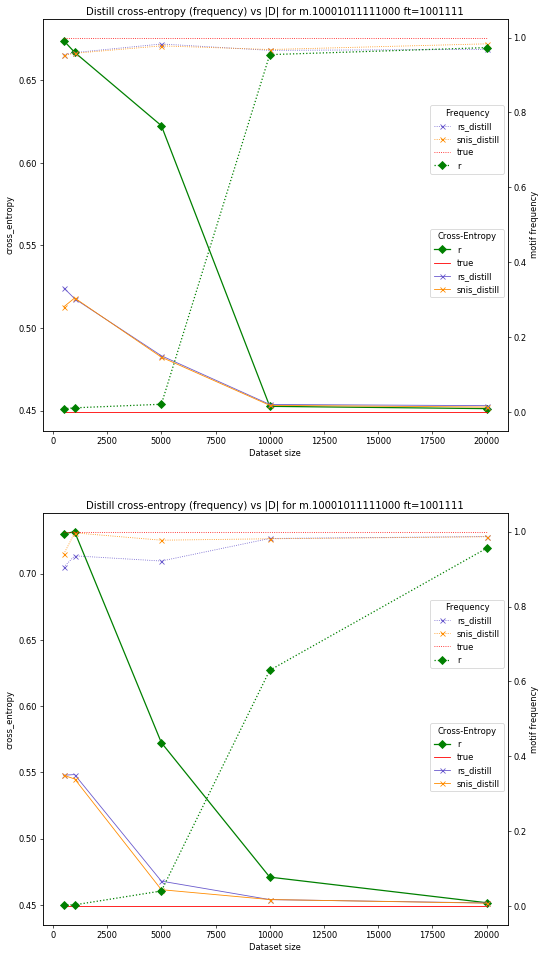

In [81]:
ms_feats = [['m.10001011111000','1001111']]
seeds = [4444, 1234]
fig=plt.figure(figsize=(10,10*len(ms_feats)*len(seeds)), dpi= 60, facecolor='w', edgecolor='k')

n = 30

data_pl = list(zip(*d_pl))
train_1 = ['rs', 'snis_r']
train_2 = ['distill']
train_r = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]
ds_range = [500, 1000, 5000, 10000, 20000]


def get_freq(s):
    # tstamp+'_'+job+'_'+str(motif_freq)+'_'+str(avg_len) +'_'+str(motif_freq_r)+'_'+str(avg_len_r)
    return float(s.split('_')[-4])

i=0
for m, feat in ms_feats:
    for sd in seeds:
        #plt.subplot(1, len(ms_feats), i+1)
        ax1 = fig.add_subplot(len(ms_feats)*len(seeds), 1, i+1)
        
        # n -> motif -> feat -> ds_size -> train_reg -> 
        #[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
        #                                 10:job,10:l1_diff]
        
        ce_hybr = {t:np.array([dict_pl[n][m][feat][ds][t][sd][0][1] for ds in ds_range])
                             for t in train_r}
        ce_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][0] for t in train_r]) 
                   for ds in ds_range] 

        df1 = {'x': ds_range, 
                            'rs':  ce_hybr['rs'+'_distill_normal'], 
                            #snis_mix': ce_hybr[1], 
                            'snis_r': ce_hybr['snis_r'+'_distill_normal'],
                            'ce_r': ce_r,
                            'theor': np.array([ent_motifs[n][m]]*len(ds_range))}

        #plt.errorbar(df1['x'], np.array(df1['ce_r']).mean(1), yerr=np.array(df1['ce_r']).std(1), 
        #                 fmt='o', capthick=2, ecolor='g',color='g', capsize=5,label='r')
        ax1.plot(df1['x'], np.array(df1['ce_r']).mean(1),  
                         marker='D', color='g', label='r')
        ax1.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true')
        ax1.plot( df1['x'], df1['rs'], marker='x', color='slateblue', linewidth=1,label='rs_distill')
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        ax1.plot( df1['x'], df1['snis_r'], marker='x', color='darkorange', linewidth=1,label='snis_distill')
        ax1.set_xlabel('Dataset size')
        ax1.set_ylabel('cross_entropy')
        ax1.set_title('Distill cross-entropy (frequency) vs |D| for %s ft=%s'%(m, feat))

        ce_r_max = max(ce_r[i].max() for i in range(len(ds_range)))
        diff = ce_r_max - ent_motifs[n][m]
        ax1.set_ylim(ent_motifs[n][m]-0.05*diff, ce_r_max+0.05*diff)
        
        ax2 = ax1.twinx()
        
        freq_hybr = {t:np.array([get_freq(dict_pl[n][m][feat][ds][t][sd][0][5]) for ds in ds_range])
                             for t in train_r}
        
        freq_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][11] for t in train_r]) 
                   for ds in ds_range] 
        
        if 'mam' in m:
            theor = np.array([0.9]*len(ds_range))
        else:
            theor = np.array([1.0]*len(ds_range))

        df1 = {'x': ds_range, 
                            'rs':  freq_hybr['rs'+'_distill_normal'], 
                            #'snis_mix': freq_hybr[1], 
                            'snis_r': freq_hybr['snis_r'+'_distill_normal'],
                            'theor': theor,
                            'r_freq':freq_r}

        ax2.plot( df1['x'], df1['rs'], marker='x', color='slateblue', linewidth=1,label='rs_distill',  linestyle=':')
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        ax2.plot( df1['x'], df1['snis_r'], marker='x', color='darkorange', linewidth=1,label='snis_distill',  linestyle=':')
        ax2.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true',  linestyle=':')
        ax2.plot(df1['x'], np.array(df1['r_freq']).mean(1), marker='D', color='g', label='r',  linestyle=':')

        #ax2.xlabel('Dataset size')
        ax2.set_ylabel('motif frequency')
        #ax2.title('Motif freq vs |D| for %s ft=%s Z=%.6f'%(m, feat,z_motifs[n][m]))
        ax2.legend(title='Frequency', loc='upper right', bbox_to_anchor=(1.0, 0.8))
        ax2.set_ylim(-0.05, 1.05)
        ax1.legend(title='Cross-Entropy', loc='upper right', bbox_to_anchor=(1.0, 0.5))
        ax2.set_ylim(-0.05, 1.05)

        i += 1
        
fig.savefig("ce_freq_distill_m1s2.pdf", bbox_inches='tight')

In [82]:
# n -> motif -> feat -> ds_size -> train_reg -> seed
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
#                                 9:job,10:l1_diff,11:r_freq]

# timestamp:
# 0:mm%dd+'_'+1:%H%M+'_'+2:str(args.job)'_'+3:str(args.rl_seed)+'_'+4:str(motif_freq)+'_'+5:str(avg_len) 
# +'_'+6:str(motif_freq_r)+'_'+7:str(avg_len_r)

# ce(pi_theta)/true_ce
n = 30
train_1 = ['snis_r', 'rs']
train_2 = ['distill']
train_r = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]
ds_range = [500, 1000, 5000, 10000, 20000]

ms = ['m.10001011111000']
feats = [ '1001111']
seeds = [1234, 4444]

table = PrettyTable(['ds_size', 'train_reg', 'seed', 'pi_ce/entr', 'r_ce/entr', 'pl_ce/entr', 'pi_freq/r_freq'])
print('motif %s'%ms[0])
ce_ratios = {t+str(ds):[] for t in train_r for ds in ds_range}
for motifs, fts in [(ms, feats)]:
    for ds in ds_range:
        for t in train_r:
            for m in motifs:
                for feat in fts:
                    for sd in seeds:
                        v6 = dict_pl[n][m][feat][ds][t][sd][0]
                        entp = v6[4]
                        tmp = v6[5].split('_')
                        pi_r_freq = np.round(float(tmp[-4])/float(tmp[-2]), decimals=3)
                        
                        pi_entp = np.round(v6[1]/entp, decimals=3)
                        r_entp = np.round(v6[0]/entp, decimals=3)
                        pl_entp = np.round(v6[2]/entp, decimals=3)
                        table.add_row([ds,t[:-7], sd, pi_entp, r_entp, pl_entp, pi_r_freq])
    

    
print(table)

motif m.10001011111000
+---------+----------------+------+------------+-----------+------------+----------------+
| ds_size |   train_reg    | seed | pi_ce/entr | r_ce/entr | pl_ce/entr | pi_freq/r_freq |
+---------+----------------+------+------------+-----------+------------+----------------+
|   500   | snis_r_distill | 1234 |    1.22    |   1.625   |   1.226    |     235.1      |
|   500   | snis_r_distill | 4444 |   1.142    |   1.496   |   1.145    |    125.289     |
|   500   |   rs_distill   | 1234 |    1.22    |   1.625   |   1.225    |    348.231     |
|   500   |   rs_distill   | 4444 |   1.167    |   1.505   |   1.176    |    101.468     |
|   1000  | snis_r_distill | 1234 |   1.214    |   1.629   |   1.242    |    311.562     |
|   1000  | snis_r_distill | 4444 |   1.154    |   1.485   |   1.162    |     84.035     |
|   1000  |   rs_distill   | 1234 |   1.221    |   1.629   |   1.246    |    259.889     |
|   1000  |   rs_distill   | 4444 |   1.153    |   1.485   |   1.16

# Distillation: same seed and different motifs

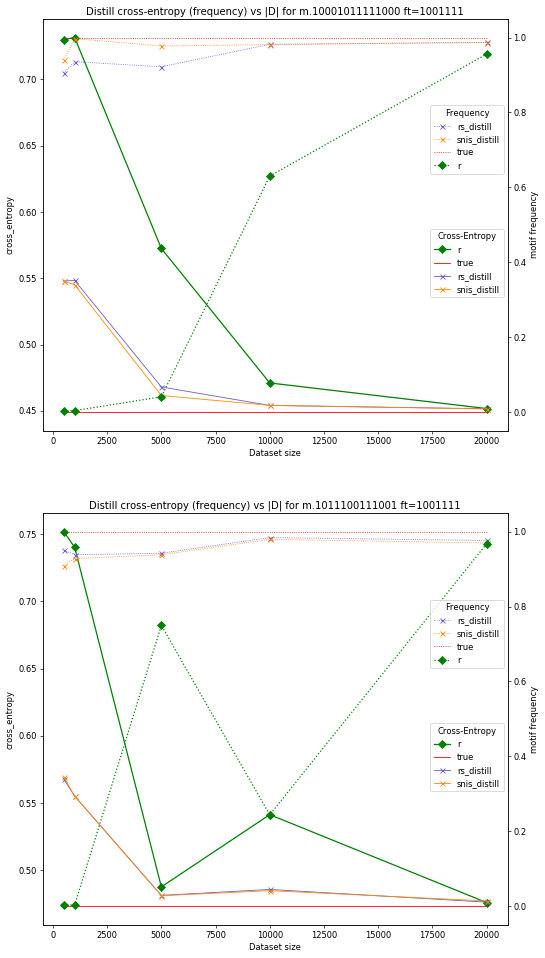

In [83]:
ms_feats = [['m.10001011111000','1001111'], ['m.1011100111001', '1001111']]
seeds = [1234]
fig=plt.figure(figsize=(10,10*len(ms_feats)*len(seeds)), dpi= 60, facecolor='w', edgecolor='k')

n = 30

data_pl = list(zip(*d_pl))
train_1 = ['rs', 'snis_r']
train_2 = ['distill']
train_r = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]
ds_range = [500, 1000, 5000, 10000, 20000]


def get_freq(s):
    # tstamp+'_'+job+'_'+str(motif_freq)+'_'+str(avg_len) +'_'+str(motif_freq_r)+'_'+str(avg_len_r)
    return float(s.split('_')[-4])

i=0
for m, feat in ms_feats:
    for sd in seeds:
        #plt.subplot(1, len(ms_feats), i+1)
        ax1 = fig.add_subplot(len(ms_feats)*len(seeds), 1, i+1)
        
        # n -> motif -> feat -> ds_size -> train_reg -> 
        #[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
        #                                 10:job,10:l1_diff]
        
        ce_hybr = {t:np.array([dict_pl[n][m][feat][ds][t][sd][0][1] for ds in ds_range])
                             for t in train_r}
        ce_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][0] for t in train_r]) 
                   for ds in ds_range] 

        df1 = {'x': ds_range, 
                            'rs':  ce_hybr['rs'+'_distill_normal'], 
                            #snis_mix': ce_hybr[1], 
                            'snis_r': ce_hybr['snis_r'+'_distill_normal'],
                            'ce_r': ce_r,
                            'theor': np.array([ent_motifs[n][m]]*len(ds_range))}

        #plt.errorbar(df1['x'], np.array(df1['ce_r']).mean(1), yerr=np.array(df1['ce_r']).std(1), 
        #                 fmt='o', capthick=2, ecolor='g',color='g', capsize=5,label='r')
        ax1.plot(df1['x'], np.array(df1['ce_r']).mean(1),  
                         marker='D', color='g', label='r')
        ax1.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true')
        ax1.plot( df1['x'], df1['rs'], marker='x', color='slateblue', linewidth=1,label='rs_distill')
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        ax1.plot( df1['x'], df1['snis_r'], marker='x', color='darkorange', linewidth=1,label='snis_distill')
        ax1.set_xlabel('Dataset size')
        ax1.set_ylabel('cross_entropy')
        ax1.set_title('Distill cross-entropy (frequency) vs |D| for %s ft=%s'%(m, feat))
        ce_r_max = max(ce_r[i].max() for i in range(len(ds_range)))
        diff = ce_r_max - ent_motifs[n][m]
        ax1.set_ylim(ent_motifs[n][m]-0.05*diff, ce_r_max+0.05*diff)
        
        ax2 = ax1.twinx()
        
        freq_hybr = {t:np.array([get_freq(dict_pl[n][m][feat][ds][t][sd][0][5]) for ds in ds_range])
                             for t in train_r}
        
        freq_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][11] for t in train_r]) 
                   for ds in ds_range] 
        
        if 'mam' in m:
            theor = np.array([0.9]*len(ds_range))
        else:
            theor = np.array([1.0]*len(ds_range))

        df1 = {'x': ds_range, 
                            'rs':  freq_hybr['rs'+'_distill_normal'], 
                            #'snis_mix': freq_hybr[1], 
                            'snis_r': freq_hybr['snis_r'+'_distill_normal'],
                            'theor': theor,
                            'r_freq':freq_r}

        ax2.plot( df1['x'], df1['rs'], marker='x', color='slateblue', linewidth=1,label='rs_distill',  linestyle=':')
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        ax2.plot( df1['x'], df1['snis_r'], marker='x', color='darkorange', linewidth=1,label='snis_distill',  linestyle=':')
        ax2.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true',  linestyle=':')
        ax2.plot(df1['x'], np.array(df1['r_freq']).mean(1), marker='D', color='g', label='r',  linestyle=':')

        #ax2.xlabel('Dataset size')
        ax2.set_ylabel('motif frequency')
        #ax2.title('Motif freq vs |D| for %s ft=%s Z=%.6f'%(m, feat,z_motifs[n][m]))
        ax2.legend(title='Frequency', loc='upper right', bbox_to_anchor=(1.0, 0.8))
        ax2.set_ylim(-0.05, 1.05)
        ax1.legend(title='Cross-Entropy', loc='upper right', bbox_to_anchor=(1.0, 0.5))
        ax2.set_ylim(-0.05, 1.05)

        i += 1
        
fig.savefig("ce_freq_distill_m2s1.pdf", bbox_inches='tight')

In [84]:
# n -> motif -> feat -> ds_size -> train_reg -> seed
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
#                                 9:job,10:l1_diff,11:r_freq]

# timestamp:
# 0:mm%dd+'_'+1:%H%M+'_'+2:str(args.job)'_'+3:str(args.rl_seed)+'_'+4:str(motif_freq)+'_'+5:str(avg_len) 
# +'_'+6:str(motif_freq_r)+'_'+7:str(avg_len_r)

# ce(pi_theta)/true_ce
n = 30
train_1 = ['snis_r', 'rs']
train_2 = ['distill']
train_r = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]
ds_range = [500, 1000, 5000, 10000, 20000]

ms = ['m.10001011111000', 'm.1011100111001']
feats = [ '1001111']
seeds = [1234]

table = PrettyTable(['ds_size', 'train_reg', 'motif', 'pi_ce/entr', 'r_ce/entr', 'pl_ce/entr', 'pi_freq/r_freq'])
print('seed %s'%seeds[0])
ce_ratios = {t+str(ds):[] for t in train_r for ds in ds_range}
for motifs, fts in [(ms, feats)]:
    for ds in ds_range:
        for t in train_r:
            for m in motifs:
                for feat in fts:
                    for sd in seeds:
                        v6 = dict_pl[n][m][feat][ds][t][sd][0]
                        entp = v6[4]
                        tmp = v6[5].split('_')
                        pi_r_freq = np.round(float(tmp[-4])/float(tmp[-2]), decimals=3)
                        
                        pi_entp = np.round(v6[1]/entp, decimals=3)
                        r_entp = np.round(v6[0]/entp, decimals=3)
                        pl_entp = np.round(v6[2]/entp, decimals=3)
                        table.add_row([ds,t[:-7], m, pi_entp, r_entp, pl_entp, pi_r_freq])
    

    
print(table)

seed 1234
+---------+----------------+------------------+------------+-----------+------------+----------------+
| ds_size |   train_reg    |      motif       | pi_ce/entr | r_ce/entr | pl_ce/entr | pi_freq/r_freq |
+---------+----------------+------------------+------------+-----------+------------+----------------+
|   500   | snis_r_distill | m.10001011111000 |    1.22    |   1.625   |   1.226    |     235.1      |
|   500   | snis_r_distill | m.1011100111001  |   1.203    |   1.588   |   1.203    |    303.133     |
|   500   |   rs_distill   | m.10001011111000 |    1.22    |   1.625   |   1.225    |    348.231     |
|   500   |   rs_distill   | m.1011100111001  |   1.199    |   1.588   |   1.203    |    296.938     |
|   1000  | snis_r_distill | m.10001011111000 |   1.214    |   1.629   |   1.242    |    311.562     |
|   1000  | snis_r_distill | m.1011100111001  |   1.173    |   1.564   |   1.178    |    257.833     |
|   1000  |   rs_distill   | m.10001011111000 |   1.221    |   

# DPG: different seeds and same motif

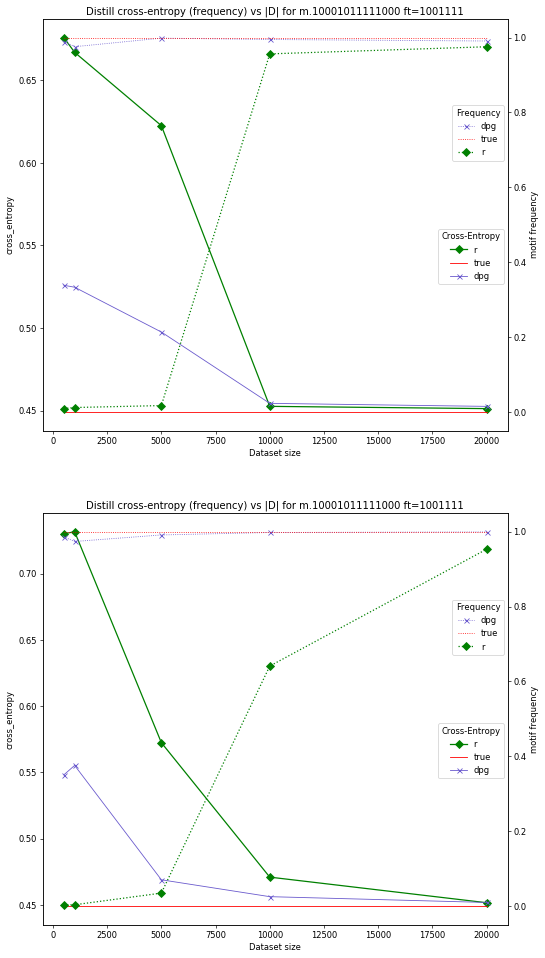

In [85]:
ms_feats = [['m.10001011111000','1001111']]
seeds = [4444, 1234]
fig=plt.figure(figsize=(10,10*len(ms_feats)*len(seeds)), dpi= 60, facecolor='w', edgecolor='k')

n = 30

data_pl = list(zip(*d_pl))
train_1 = ['rs']
train_2 = ['dpg_stable_q']
train_r = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]
ds_range = [500, 1000, 5000, 10000, 20000]


def get_freq(s):
    # tstamp+'_'+job+'_'+str(motif_freq)+'_'+str(avg_len) +'_'+str(motif_freq_r)+'_'+str(avg_len_r)
    return float(s.split('_')[-4])

i=0
for m, feat in ms_feats:
    for sd in seeds:
        #plt.subplot(1, len(ms_feats), i+1)
        ax1 = fig.add_subplot(len(ms_feats)*len(seeds), 1, i+1)
        
        # n -> motif -> feat -> ds_size -> train_reg -> 
        #[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
        #                                 10:job,10:l1_diff]
        
        ce_hybr = {t:np.array([dict_pl[n][m][feat][ds][t][sd][0][1] for ds in ds_range])
                             for t in train_r}
        ce_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][0] for t in train_r]) 
                   for ds in ds_range] 

        df1 = {'x': ds_range, 
                            'rs':  ce_hybr['rs'+'_dpg_stable_q_normal'], 
                            #snis_mix': ce_hybr[1], 
                            #'snis_r': ce_hybr['snis_r'+'_dpg_stable_q_normal'],
                            'ce_r': ce_r,
                            'theor': np.array([ent_motifs[n][m]]*len(ds_range))}

        #plt.errorbar(df1['x'], np.array(df1['ce_r']).mean(1), yerr=np.array(df1['ce_r']).std(1), 
        #                 fmt='o', capthick=2, ecolor='g',color='g', capsize=5,label='r')
        ax1.plot(df1['x'], np.array(df1['ce_r']).mean(1),  
                         marker='D', color='g', label='r')
        ax1.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true')
        ax1.plot( df1['x'], df1['rs'], marker='x', color='slateblue', linewidth=1,label='dpg')
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        #ax1.plot( df1['x'], df1['snis_r'], marker='x', color='darkorange', linewidth=1,label='snis_dpg')
        ax1.set_xlabel('Dataset size')
        ax1.set_ylabel('cross_entropy')
        ax1.set_title('Distill cross-entropy (frequency) vs |D| for %s ft=%s'%(m, feat))

        ce_r_max = max(ce_r[i].max() for i in range(len(ds_range)))
        diff = ce_r_max - ent_motifs[n][m]
        ax1.set_ylim(ent_motifs[n][m]-0.05*diff, ce_r_max+0.05*diff)
        
        ax2 = ax1.twinx()
        
        freq_hybr = {t:np.array([get_freq(dict_pl[n][m][feat][ds][t][sd][0][5]) for ds in ds_range])
                             for t in train_r}
        
        freq_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][11] for t in train_r]) 
                   for ds in ds_range] 
        
        if 'mam' in m:
            theor = np.array([0.9]*len(ds_range))
        else:
            theor = np.array([1.0]*len(ds_range))

        df1 = {'x': ds_range, 
                            'rs':  freq_hybr['rs'+'_dpg_stable_q_normal'], 
                            #'snis_mix': freq_hybr[1], 
                            #'snis_r': freq_hybr['snis_r'+'_dpg_stable_q_normal'],
                            'theor': theor,
                            'r_freq':freq_r}

        ax2.plot( df1['x'], df1['rs'], marker='x', color='slateblue', linewidth=1,label='dpg',  linestyle=':')
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        #ax2.plot( df1['x'], df1['snis_r'], marker='x', color='darkorange', linewidth=1,label='snis_dpg',  linestyle=':')
        ax2.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true',  linestyle=':')
        ax2.plot(df1['x'], np.array(df1['r_freq']).mean(1), marker='D', color='g', label='r',  linestyle=':')

        #ax2.xlabel('Dataset size')
        ax2.set_ylabel('motif frequency')
        #ax2.title('Motif freq vs |D| for %s ft=%s Z=%.6f'%(m, feat,z_motifs[n][m]))
        ax2.legend(title='Frequency', loc='upper right', bbox_to_anchor=(1.0, 0.8))
        ax2.set_ylim(-0.05, 1.05)
        ax1.legend(title='Cross-Entropy', loc='upper right', bbox_to_anchor=(1.0, 0.5))
        ax2.set_ylim(-0.05, 1.05)

        i += 1
        
fig.savefig("ce_freq_dpg_m1s2.pdf", bbox_inches='tight')

In [86]:
# n -> motif -> feat -> ds_size -> train_reg -> seed
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
#                                 9:job,10:l1_diff,11:r_freq]

# timestamp:
# 0:mm%dd+'_'+1:%H%M+'_'+2:str(args.job)'_'+3:str(args.rl_seed)+'_'+4:str(motif_freq)+'_'+5:str(avg_len) 
# +'_'+6:str(motif_freq_r)+'_'+7:str(avg_len_r)

# ce(pi_theta)/true_ce
n = 30
train_1 = ['rs']
train_2 = ['dpg_stable_q']
train_r = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]
ds_range = [500, 1000, 5000, 10000, 20000]

ms = ['m.10001011111000']
feats = [ '1001111']
seeds = [1234, 4444]

table = PrettyTable(['ds_size', 'train_reg', 'seed', 'pi_ce/entr', 'r_ce/entr', 'pl_ce/entr', 'pi_freq/r_freq'])
print('motif %s'%ms[0])
ce_ratios = {t+str(ds):[] for t in train_r for ds in ds_range}
for motifs, fts in [(ms, feats)]:
    for ds in ds_range:
        for t in train_r:
            for m in motifs:
                for feat in fts:
                    for sd in seeds:
                        v6 = dict_pl[n][m][feat][ds][t][sd][0]
                        entp = v6[4]
                        tmp = v6[5].split('_')
                        pi_r_freq = np.round(float(tmp[-4])/float(tmp[-2]), decimals=3)
                        
                        pi_entp = np.round(v6[1]/entp, decimals=3)
                        r_entp = np.round(v6[0]/entp, decimals=3)
                        pl_entp = np.round(v6[2]/entp, decimals=3)
                        table.add_row([ds,t[:-7], sd, pi_entp, r_entp, pl_entp, pi_r_freq])
    

    
print(table)

motif m.10001011111000
+---------+-----------------+------+------------+-----------+------------+----------------+
| ds_size |    train_reg    | seed | pi_ce/entr | r_ce/entr | pl_ce/entr | pi_freq/r_freq |
+---------+-----------------+------+------------+-----------+------------+----------------+
|   500   | rs_dpg_stable_q | 1234 |    1.22    |   1.625   |   1.225    |    308.188     |
|   500   | rs_dpg_stable_q | 4444 |   1.171    |   1.505   |   1.176    |    109.911     |
|   1000  | rs_dpg_stable_q | 1234 |   1.236    |   1.629   |   1.246    |    270.556     |
|   1000  | rs_dpg_stable_q | 4444 |   1.168    |   1.485   |   1.167    |     82.678     |
|   5000  | rs_dpg_stable_q | 1234 |   1.044    |   1.275   |   1.044    |     28.489     |
|   5000  | rs_dpg_stable_q | 4444 |   1.108    |   1.386   |   1.109    |     58.729     |
|  10000  | rs_dpg_stable_q | 1234 |   1.016    |   1.049   |   1.019    |     1.556      |
|  10000  | rs_dpg_stable_q | 4444 |   1.012    |   1.008

# DPG: same seed and different motifs

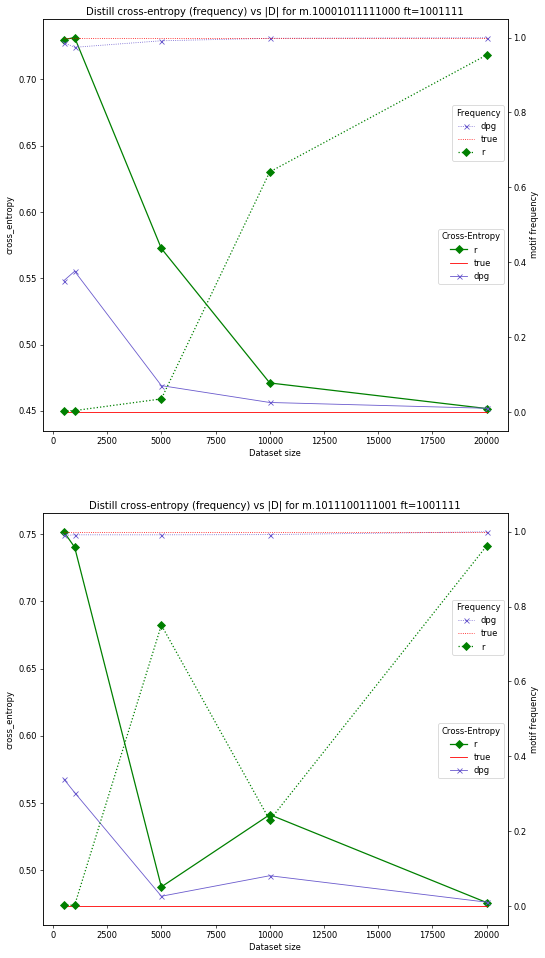

In [87]:
ms_feats = [['m.10001011111000','1001111'], ['m.1011100111001', '1001111']]
seeds = [1234]
fig=plt.figure(figsize=(10,10*len(ms_feats)*len(seeds)), dpi= 60, facecolor='w', edgecolor='k')

n = 30

data_pl = list(zip(*d_pl))
train_1 = ['rs']
train_2 = ['dpg_stable_q']
train_r = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]
ds_range = [500, 1000, 5000, 10000, 20000]


def get_freq(s):
    # tstamp+'_'+job+'_'+str(motif_freq)+'_'+str(avg_len) +'_'+str(motif_freq_r)+'_'+str(avg_len_r)
    return float(s.split('_')[-4])

i=0
for m, feat in ms_feats:
    for sd in seeds:
        #plt.subplot(1, len(ms_feats), i+1)
        ax1 = fig.add_subplot(len(ms_feats)*len(seeds), 1, i+1)
        
        # n -> motif -> feat -> ds_size -> train_reg -> 
        #[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
        #                                 10:job,10:l1_diff]
        
        ce_hybr = {t:np.array([dict_pl[n][m][feat][ds][t][sd][0][1] for ds in ds_range])
                             for t in train_r}
        ce_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][0] for t in train_r]) 
                   for ds in ds_range] 

        df1 = {'x': ds_range, 
                            'rs':  ce_hybr['rs'+'_dpg_stable_q_normal'], 
                            #snis_mix': ce_hybr[1], 
                            #'snis_r': ce_hybr['snis_r'+'_dpg_stable_q_normal'],
                            'ce_r': ce_r,
                            'theor': np.array([ent_motifs[n][m]]*len(ds_range))}

        #plt.errorbar(df1['x'], np.array(df1['ce_r']).mean(1), yerr=np.array(df1['ce_r']).std(1), 
        #                 fmt='o', capthick=2, ecolor='g',color='g', capsize=5,label='r')
        ax1.plot(df1['x'], np.array(df1['ce_r']).mean(1),  
                         marker='D', color='g', label='r')
        ax1.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true')
        ax1.plot( df1['x'], df1['rs'], marker='x', color='slateblue', linewidth=1,label='dpg')
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        #ax1.plot( df1['x'], df1['snis_r'], marker='x', color='darkorange', linewidth=1,label='snis_dpg')
        ax1.set_xlabel('Dataset size')
        ax1.set_ylabel('cross_entropy')
        ax1.set_title('Distill cross-entropy (frequency) vs |D| for %s ft=%s'%(m, feat))

        ce_r_max = max(ce_r[i].max() for i in range(len(ds_range)))
        diff = ce_r_max - ent_motifs[n][m]
        ax1.set_ylim(ent_motifs[n][m]-0.05*diff, ce_r_max+0.05*diff)
        
        ax2 = ax1.twinx()
        
        freq_hybr = {t:np.array([get_freq(dict_pl[n][m][feat][ds][t][sd][0][5]) for ds in ds_range])
                             for t in train_r}
        
        freq_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][11] for t in train_r]) 
                   for ds in ds_range] 
        
        if 'mam' in m:
            theor = np.array([0.9]*len(ds_range))
        else:
            theor = np.array([1.0]*len(ds_range))

        df1 = {'x': ds_range, 
                            'rs':  freq_hybr['rs'+'_dpg_stable_q_normal'], 
                            #'snis_mix': freq_hybr[1], 
                            #'snis_r': freq_hybr['snis_r'+'_dpg_stable_q_normal'],
                            'theor': theor,
                            'r_freq':freq_r}

        ax2.plot( df1['x'], df1['rs'], marker='x', color='slateblue', linewidth=1,label='dpg',  linestyle=':')
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        #ax2.plot( df1['x'], df1['snis_r'], marker='x', color='darkorange', linewidth=1,label='snis_dpg',  linestyle=':')
        ax2.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true',  linestyle=':')
        ax2.plot(df1['x'], np.array(df1['r_freq']).mean(1), marker='D', color='g', label='r',  linestyle=':')

        #ax2.xlabel('Dataset size')
        ax2.set_ylabel('motif frequency')
        #ax2.title('Motif freq vs |D| for %s ft=%s Z=%.6f'%(m, feat,z_motifs[n][m]))
        ax2.legend(title='Frequency', loc='upper right', bbox_to_anchor=(1.0, 0.8))
        ax2.set_ylim(-0.05, 1.05)
        ax1.legend(title='Cross-Entropy', loc='upper right', bbox_to_anchor=(1.0, 0.5))
        ax2.set_ylim(-0.05, 1.05)

        i += 1
        
fig.savefig("ce_freq_dpg_m2s1.pdf", bbox_inches='tight')

In [88]:
# n -> motif -> feat -> ds_size -> train_reg -> seed
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
#                                 9:job,10:l1_diff,11:r_freq]

# timestamp:
# 0:mm%dd+'_'+1:%H%M+'_'+2:str(args.job)'_'+3:str(args.rl_seed)+'_'+4:str(motif_freq)+'_'+5:str(avg_len) 
# +'_'+6:str(motif_freq_r)+'_'+7:str(avg_len_r)


ms = ['m.10001011111000', 'm.1011100111001']
feats = [ '1001111']
seeds = [1234]

table = PrettyTable(['ds_size', 'train_reg', 'seed', 'pi_ce/entr', 'r_ce/entr', 'pl_ce/entr', 'pi_freq/r_freq'])
print('seed %s'%seeds[0])
ce_ratios = {t+str(ds):[] for t in train_r for ds in ds_range}
for motifs, fts in [(ms, feats)]:
    for ds in ds_range:
        for t in train_r:
            for m in motifs:
                for feat in fts:
                    for sd in seeds:
                        v6 = dict_pl[n][m][feat][ds][t][sd][0]
                        entp = v6[4]
                        tmp = v6[5].split('_')
                        pi_r_freq = np.round(float(tmp[-4])/float(tmp[-2]), decimals=3)
                        
                        pi_entp = np.round(v6[1]/entp, decimals=3)
                        r_entp = np.round(v6[0]/entp, decimals=3)
                        pl_entp = np.round(v6[2]/entp, decimals=3)
                        table.add_row([ds,t[:-7], sd, pi_entp, r_entp, pl_entp, pi_r_freq])
    

    
print(table)

seed 1234
+---------+-----------------+------+------------+-----------+------------+----------------+
| ds_size |    train_reg    | seed | pi_ce/entr | r_ce/entr | pl_ce/entr | pi_freq/r_freq |
+---------+-----------------+------+------------+-----------+------------+----------------+
|   500   | rs_dpg_stable_q | 1234 |    1.22    |   1.625   |   1.225    |    308.188     |
|   500   | rs_dpg_stable_q | 1234 |    1.2     |   1.588   |   1.203    |    380.769     |
|   1000  | rs_dpg_stable_q | 1234 |   1.236    |   1.629   |   1.246    |    270.556     |
|   1000  | rs_dpg_stable_q | 1234 |   1.178    |   1.564   |    1.18    |     413.25     |
|   5000  | rs_dpg_stable_q | 1234 |   1.044    |   1.275   |   1.044    |     28.489     |
|   5000  | rs_dpg_stable_q | 1234 |   1.016    |    1.03   |   1.016    |     1.321      |
|  10000  | rs_dpg_stable_q | 1234 |   1.016    |   1.049   |   1.019    |     1.556      |
|  10000  | rs_dpg_stable_q | 1234 |   1.048    |   1.144   |   1.056 

# D-PG vs PG

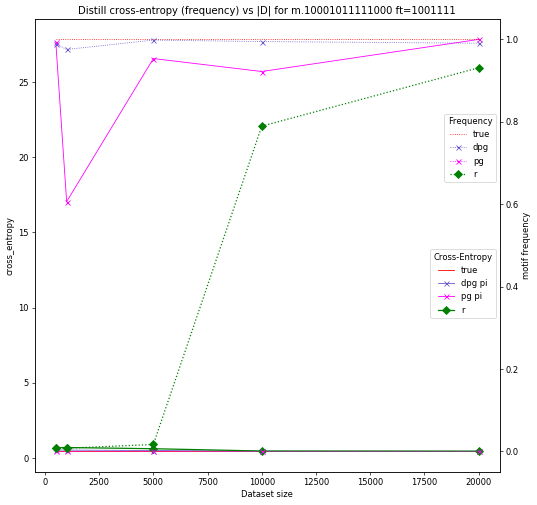

In [89]:
ms_feats = [['m.10001011111000','1001111']]
seeds = [4444]
fig=plt.figure(figsize=(10,10*len(ms_feats)*len(seeds)), dpi= 60, facecolor='w', edgecolor='k')

n = 30

data_pl = list(zip(*d_pl))
train_1 = ['rs']
train_2 = ['dpg_stable_q', 'pg']
train_r = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]
ds_range = [500, 1000, 5000, 10000, 20000]


def get_freq(s):
    # tstamp+'_'+job+'_'+str(motif_freq)+'_'+str(avg_len) +'_'+str(motif_freq_r)+'_'+str(avg_len_r)
    return float(s.split('_')[-4])

i=0
for m, feat in ms_feats:
    for sd in seeds:
        #plt.subplot(1, len(ms_feats), i+1)
        ax1 = fig.add_subplot(len(ms_feats)*len(seeds), 1, i+1)
        
        # n -> motif -> feat -> ds_size -> train_reg -> 
        #[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
        #                                 10:job,10:l1_diff]
        
        ce_hybr = {t:np.array([dict_pl[n][m][feat][ds][t][sd][0][1] for ds in ds_range])
                             for t in train_r}
        ce_hybr_pl = {t:np.array([dict_pl[n][m][feat][ds][t][sd][0][2] for ds in ds_range])
                             for t in train_r}
        ce_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][0] for t in train_r]) 
                   for ds in ds_range] 

        df1 = {'x': ds_range, 
                            'dpg':  ce_hybr['rs'+'_dpg_stable_q_normal'],
                            #snis_mix': ce_hybr[1], 
                            'wdpg': ce_hybr['rs'+'_pg_normal'],
                            'ce_r': ce_r,
                            'theor': np.array([ent_motifs[n][m]]*len(ds_range))}

        #plt.errorbar(df1['x'], np.array(df1['ce_r']).mean(1), yerr=np.array(df1['ce_r']).std(1), 
        #                 fmt='o', capthick=2, ecolor='g',color='g', capsize=5,label='r')
        
        ax1.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true')
        ax1.plot( df1['x'], df1['dpg'], marker='x', color='slateblue', linewidth=1,label='dpg pi')
        
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        ax1.plot( df1['x'], df1['wdpg'], marker='x', color='magenta', linewidth=1,label='pg pi')
        
        ax1.plot(df1['x'], np.array(df1['ce_r']).mean(1),  
                         marker='D', color='g', label='r')
        ax1.set_xlabel('Dataset size')
        ax1.set_ylabel('cross_entropy')
        ax1.set_title('Distill cross-entropy (frequency) vs |D| for %s ft=%s'%(m, feat))
        
        ce_r_max = max(ce_hybr['rs'+'_pg_normal'][i].max() for i in range(len(ds_range)))
        diff = ce_r_max - ent_motifs[n][m]
        ax1.set_ylim(ent_motifs[n][m]-0.05*diff, ce_r_max+0.05*diff)
        
        ax2 = ax1.twinx()
        
        freq_hybr = {t:np.array([get_freq(dict_pl[n][m][feat][ds][t][sd][0][5]) for ds in ds_range])
                             for t in train_r}
        
        freq_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][11] for t in train_r]) 
                   for ds in ds_range] 
        
        if 'mam' in m:
            theor = np.array([0.9]*len(ds_range))
        else:
            theor = np.array([1.0]*len(ds_range))

        df1 = {'x': ds_range, 
                            'rs':  freq_hybr['rs'+'_dpg_stable_q_normal'], 
                            #'snis_mix': freq_hybr[1], 
                            'wrs': freq_hybr['rs'+'_pg_normal'],
                            'theor': theor,
                            'r_freq':freq_r}

        ax2.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true',  linestyle=':')
        ax2.plot( df1['x'], df1['rs'], marker='x', color='slateblue', linewidth=1,label='dpg',  linestyle=':')
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        ax2.plot( df1['x'], df1['wrs'], marker='x', color='magenta', linewidth=1,label='pg',  linestyle=':')
        
        ax2.plot(df1['x'], np.array(df1['r_freq']).mean(1), marker='D', color='g', label='r',  linestyle=':')

        #ax2.xlabel('Dataset size')
        ax2.set_ylabel('motif frequency')
        #ax2.title('Motif freq vs |D| for %s ft=%s Z=%.6f'%(m, feat,z_motifs[n][m]))
        ax2.legend(title='Frequency', loc='upper right', bbox_to_anchor=(1.0, 0.8))
        ax2.set_ylim(-0.05, 1.05)
        ax1.legend(title='Cross-Entropy', loc='upper right', bbox_to_anchor=(1.0, 0.5))

        i += 1
        
fig.savefig("ce_freq_dpg_pg.pdf", bbox_inches='tight')

In [90]:
# n -> motif -> feat -> ds_size -> train_reg -> seed
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
#                                 9:job,10:l1_diff,11:r_freq]

# timestamp:
# 0:mm%dd+'_'+1:%H%M+'_'+2:str(args.job)'_'+3:str(args.rl_seed)+'_'+4:str(motif_freq)+'_'+5:str(avg_len) 
# +'_'+6:str(motif_freq_r)+'_'+7:str(avg_len_r)


ms = ['m.10001011111000']
feats = [ '1001111']
train_1 = ['rs']
train_2 = ['dpg_stable_q', 'pg']
train_r = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]

table = PrettyTable(['ds_size', 'entp', 'DPG:pi_ce', 'DPG:r_ce', 'DPG:pi_f/r_f', 'PG:pi_ce', 'PG:r_ce', 'PG:pi_f/r_f'])
print('seed %s'%seeds[0])
ce_ratios = {t+str(ds):[] for t in train_r for ds in ds_range}
for motifs, fts in [(ms, feats)]:
    for ds in ds_range:
            for m in motifs:
                for feat in fts:
                    for sd in seeds:
                        t_ds, t_dpg = train_r
                        ds_v6 = dict_pl[n][m][feat][ds][t_ds][sd][0]
                        dpg_v6 = dict_pl[n][m][feat][ds][t_dpg][sd][0]
                        entp = ds_v6[4]
                        line = []
                        for v6 in [ds_v6, dpg_v6]:
                            tmp = v6[5].split('_')
                            pi_r_freq = np.round(float(tmp[-4])/float(tmp[-2]), decimals=3)

                            pi_entp = np.round(v6[1], decimals=5)
                            r_entp = np.round(v6[0], decimals=3)
                            line += [pi_entp, r_entp, pi_r_freq]
                        table.add_row([ds, np.round(entp, decimals=3)] + line)
    

    
print(table)

seed 4444
+---------+-------+-----------+----------+--------------+----------+---------+-------------+
| ds_size |  entp | DPG:pi_ce | DPG:r_ce | DPG:pi_f/r_f | PG:pi_ce | PG:r_ce | PG:pi_f/r_f |
+---------+-------+-----------+----------+--------------+----------+---------+-------------+
|   500   | 0.449 |  0.52588  |  0.676   |   109.911    | 27.65596 |  0.676  |     0.0     |
|   1000  | 0.449 |  0.52469  |  0.667   |    82.678    | 17.04922 |  0.725  |     0.0     |
|   5000  | 0.449 |  0.49755  |  0.623   |    58.729    | 26.56755 |  0.612  |     0.0     |
|  10000  | 0.449 |  0.45433  |  0.453   |     1.04     | 25.70446 |  0.475  |     0.0     |
|  20000  | 0.449 |   0.4525  |  0.451   |    1.016     | 27.83858 |  0.455  |     0.0     |
+---------+-------+-----------+----------+--------------+----------+---------+-------------+


# Influence of P_lambda: D-PG vs WhiteNoise D-PG

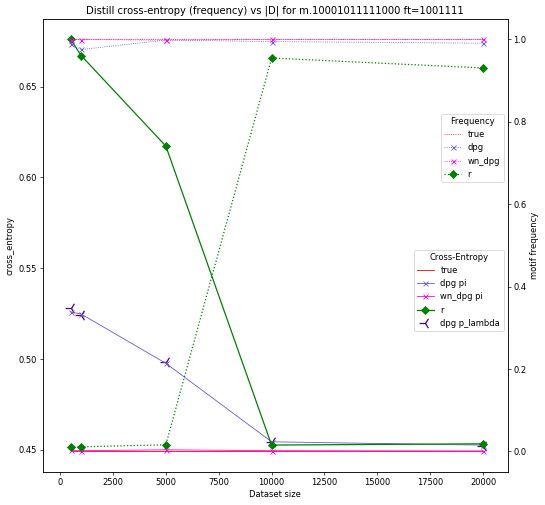

In [91]:
ms_feats = [['m.10001011111000','1001111']]
seeds = [4444]
fig=plt.figure(figsize=(10,10*len(ms_feats)*len(seeds)), dpi= 60, facecolor='w', edgecolor='k')

n = 30

data_pl = list(zip(*d_pl))
train_1 = ['rs']
train_2 = ['dpg_stable_q', 'wn_dpg_stable_q']
train_r = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]
ds_range = [500, 1000, 5000, 10000, 20000]


def get_freq(s):
    # tstamp+'_'+job+'_'+str(motif_freq)+'_'+str(avg_len) +'_'+str(motif_freq_r)+'_'+str(avg_len_r)
    return float(s.split('_')[-4])

i=0
for m, feat in ms_feats:
    for sd in seeds:
        #plt.subplot(1, len(ms_feats), i+1)
        ax1 = fig.add_subplot(len(ms_feats)*len(seeds), 1, i+1)
        
        # n -> motif -> feat -> ds_size -> train_reg -> 
        #[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
        #                                 10:job,10:l1_diff]
        
        ce_hybr = {t:np.array([dict_pl[n][m][feat][ds][t][sd][0][1] for ds in ds_range])
                             for t in train_r}
        ce_hybr_pl = {t:np.array([dict_pl[n][m][feat][ds][t][sd][0][2] for ds in ds_range])
                             for t in train_r}
        ce_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][0] for t in train_r]) 
                   for ds in ds_range] 

        df1 = {'x': ds_range, 
                            'dpg':  ce_hybr['rs'+'_dpg_stable_q_normal'],
                            'dpg_pl':  ce_hybr_pl['rs'+'_dpg_stable_q_normal'],
                            #snis_mix': ce_hybr[1], 
                            'wdpg': ce_hybr['rs'+'_wn_dpg_stable_q_normal'],
                            'ce_r': ce_r,
                            'theor': np.array([ent_motifs[n][m]]*len(ds_range))}

        #plt.errorbar(df1['x'], np.array(df1['ce_r']).mean(1), yerr=np.array(df1['ce_r']).std(1), 
        #                 fmt='o', capthick=2, ecolor='g',color='g', capsize=5,label='r')
        
        ax1.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true')
        ax1.scatter(df1['x'], df1['dpg_pl'], marker='3', color='indigo',s=200, label='dpg p_lambda')
        ax1.plot( df1['x'], df1['dpg'], marker='x', color='slateblue', linewidth=1,label='dpg pi')
        
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        ax1.plot( df1['x'], df1['wdpg'], marker='x', color='magenta', linewidth=1,label='wn_dpg pi')
        
        ax1.plot(df1['x'], np.array(df1['ce_r']).mean(1),  
                         marker='D', color='g', label='r')
        ax1.set_xlabel('Dataset size')
        ax1.set_ylabel('cross_entropy')
        ax1.set_title('Distill cross-entropy (frequency) vs |D| for %s ft=%s'%(m, feat))
        
        ce_r_max = max(ce_r[i].max() for i in range(len(ds_range)))
        diff = ce_r_max - ent_motifs[n][m]
        ax1.set_ylim(ent_motifs[n][m]-0.05*diff, ce_r_max+0.05*diff)
        
        ax2 = ax1.twinx()
        
        freq_hybr = {t:np.array([get_freq(dict_pl[n][m][feat][ds][t][sd][0][5]) for ds in ds_range])
                             for t in train_r}
        
        freq_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][11] for t in train_r]) 
                   for ds in ds_range] 
        
        if 'mam' in m:
            theor = np.array([0.9]*len(ds_range))
        else:
            theor = np.array([1.0]*len(ds_range))

        df1 = {'x': ds_range, 
                            'rs':  freq_hybr['rs'+'_dpg_stable_q_normal'], 
                            #'snis_mix': freq_hybr[1], 
                            'wrs': freq_hybr['rs'+'_wn_dpg_stable_q_normal'],
                            'theor': theor,
                            'r_freq':freq_r}

        ax2.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true',  linestyle=':')
        ax2.plot( df1['x'], df1['rs'], marker='x', color='slateblue', linewidth=1,label='dpg',  linestyle=':')
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        ax2.plot( df1['x'], df1['wrs'], marker='x', color='magenta', linewidth=1,label='wn_dpg',  linestyle=':')
        
        ax2.plot(df1['x'], np.array(df1['r_freq']).mean(1), marker='D', color='g', label='r',  linestyle=':')

        #ax2.xlabel('Dataset size')
        ax2.set_ylabel('motif frequency')
        #ax2.title('Motif freq vs |D| for %s ft=%s Z=%.6f'%(m, feat,z_motifs[n][m]))
        ax2.legend(title='Frequency', loc='upper right', bbox_to_anchor=(1.0, 0.8))
        ax2.set_ylim(-0.05, 1.05)
        ax1.legend(title='Cross-Entropy', loc='upper right', bbox_to_anchor=(1.0, 0.5))

        i += 1
        
fig.savefig("ce_freq_dpg_wdpg.pdf", bbox_inches='tight')

In [92]:
# n -> motif -> feat -> ds_size -> train_reg -> seed
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
#                                 9:job,10:l1_diff,11:r_freq]

# timestamp:
# 0:mm%dd+'_'+1:%H%M+'_'+2:str(args.job)'_'+3:str(args.rl_seed)+'_'+4:str(motif_freq)+'_'+5:str(avg_len) 
# +'_'+6:str(motif_freq_r)+'_'+7:str(avg_len_r)


ms = ['m.10001011111000']
feats = [ '1001111']

table = PrettyTable(['ds_size', 'train_reg', 'pi_ce/entr', 'r_ce/entr','pi_ce','pl_ce','theor', 'pi_freq/r_freq'])
print('seed %s'%seeds[0])
ce_ratios = {t+str(ds):[] for t in train_r for ds in ds_range}
for motifs, fts in [(ms, feats)]:
    for ds in ds_range:
        for t in train_r:
            for m in motifs:
                for feat in fts:
                    for sd in seeds:
                        v6 = dict_pl[n][m][feat][ds][t][sd][0]
                        entp = v6[4]
                        tmp = v6[5].split('_')
                        pi_r_freq = np.round(float(tmp[-4])/float(tmp[-2]), decimals=3)
                        
                        pi_entp = np.round(v6[1]/entp, decimals=3)
                        pi_ce = np.round(v6[1], decimals=6)
                        r_entp = np.round(v6[0]/entp, decimals=3)
                        if 'wn_dpg' in t:
                            pl_ce = 'Theor'
                        else:
                            pl_ce = np.round(v6[2], decimals=5)
                        table.add_row([ds,t[:-7], pi_entp, r_entp, pi_ce, pl_ce,np.round(entp, decimals=5), pi_r_freq])
    

    
print(table)

seed 4444
+---------+--------------------+------------+-----------+----------+---------+---------+----------------+
| ds_size |     train_reg      | pi_ce/entr | r_ce/entr |  pi_ce   |  pl_ce  |  theor  | pi_freq/r_freq |
+---------+--------------------+------------+-----------+----------+---------+---------+----------------+
|   500   |  rs_dpg_stable_q   |   1.171    |   1.505   | 0.525878 | 0.52822 | 0.44913 |    109.911     |
|   500   | rs_wn_dpg_stable_q |   1.001    |   1.505   | 0.449569 |  Theor  | 0.44913 |     104.0      |
|   1000  |  rs_dpg_stable_q   |   1.168    |   1.485   | 0.52469  | 0.52408 | 0.44913 |     82.678     |
|   1000  | rs_wn_dpg_stable_q |   1.001    |   1.485   | 0.449424 |  Theor  | 0.44913 |     102.02     |
|   5000  |  rs_dpg_stable_q   |   1.108    |   1.386   | 0.497546 | 0.49813 | 0.44913 |     58.729     |
|   5000  | rs_wn_dpg_stable_q |   1.002    |   1.362   | 0.449916 |  Theor  | 0.44913 |     70.296     |
|  10000  |  rs_dpg_stable_q   |   1

# Distillation vs D-PG

## same seed and different motifs

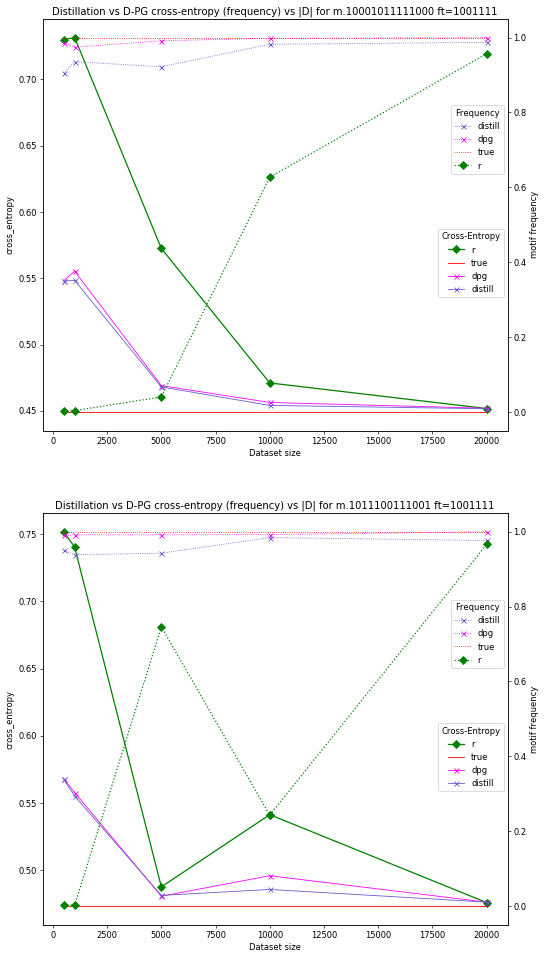

In [93]:
ms_feats = [['m.10001011111000','1001111'], ['m.1011100111001', '1001111']]
seeds = [1234]
fig=plt.figure(figsize=(10,10*len(ms_feats)*len(seeds)), dpi= 60, facecolor='w', edgecolor='k')

n = 30

data_pl = list(zip(*d_pl))
train_1 = ['rs']
train_2 = ['dpg_stable_q']
train_dpg = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]

train_2 = ['distill']
train_ds = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]
ds_range = [500, 1000, 5000, 10000, 20000]


def get_freq(s):
    # tstamp+'_'+job+'_'+str(motif_freq)+'_'+str(avg_len) +'_'+str(motif_freq_r)+'_'+str(avg_len_r)
    return float(s.split('_')[-4])

i=0
for m, feat in ms_feats:
    for sd in seeds:
        #plt.subplot(1, len(ms_feats), i+1)
        ax1 = fig.add_subplot(len(ms_feats)*len(seeds), 1, i+1)
        
        # n -> motif -> feat -> ds_size -> train_reg -> 
        #[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
        #                                 10:job,10:l1_diff]
        
        ds_ce_hybr = {t:np.array([dict_pl[n][m][feat][ds][t][sd][0][1] for ds in ds_range])
                             for t in train_ds}
        dpg_ce_hybr = {t:np.array([dict_pl[n][m][feat][ds][t][sd][0][1] for ds in ds_range])
                             for t in train_dpg}
        ce_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][0] for t in train_ds]) 
                   for ds in ds_range] 

        df1 = {'x': ds_range, 
                            'dpg':  dpg_ce_hybr['rs'+'_dpg_stable_q_normal'], 
                            'ds':  ds_ce_hybr['rs'+'_distill_normal'],
                            'ce_r': ce_r,
                            'theor': np.array([ent_motifs[n][m]]*len(ds_range))}


        ax1.plot(df1['x'], np.array(df1['ce_r']).mean(1),  
                         marker='D', color='g', label='r')
        ax1.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true')
        ax1.plot( df1['x'], df1['dpg'], marker='x', color='magenta', linewidth=1,label='dpg')
        ax1.plot( df1['x'], df1['ds'], marker='x', color='slateblue', linewidth=1,label='distill')
        ax1.set_xlabel('Dataset size')
        ax1.set_ylabel('cross_entropy')
        ax1.set_title('Distillation vs D-PG cross-entropy (frequency) vs |D| for %s ft=%s'%(m, feat))

        ce_r_max = max(ce_r[i].max() for i in range(len(ds_range)))
        diff = ce_r_max - ent_motifs[n][m]
        ax1.set_ylim(ent_motifs[n][m]-0.05*diff, ce_r_max+0.05*diff)
        
        ax2 = ax1.twinx()
        
        ds_freq_hybr = {t:np.array([get_freq(dict_pl[n][m][feat][ds][t][sd][0][5]) for ds in ds_range])
                             for t in train_ds}
        dpg_freq_hybr = {t:np.array([get_freq(dict_pl[n][m][feat][ds][t][sd][0][5]) for ds in ds_range])
                             for t in train_dpg}
        
        freq_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][11] for t in train_ds]) 
                   for ds in ds_range] 
        
        if 'mam' in m:
            theor = np.array([0.9]*len(ds_range))
        else:
            theor = np.array([1.0]*len(ds_range))

        df1 = {'x': ds_range, 
                            'dpg':  dpg_freq_hybr['rs'+'_dpg_stable_q_normal'], 
                            'ds':  ds_freq_hybr['rs'+'_distill_normal'],
                            'theor': theor,
                            'r_freq':freq_r}

        ax2.plot( df1['x'], df1['ds'], marker='x', color='slateblue', linewidth=1,label='distill',  linestyle=':')
        ax2.plot( df1['x'], df1['dpg'], marker='x', color='magenta', linewidth=1,label='dpg',  linestyle=':')
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        #ax2.plot( df1['x'], df1['snis_r'], marker='x', color='darkorange', linewidth=1,label='snis_dpg',  linestyle=':')
        ax2.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true',  linestyle=':')
        ax2.plot(df1['x'], np.array(df1['r_freq']).mean(1), marker='D', color='g', label='r',  linestyle=':')

        #ax2.xlabel('Dataset size')
        ax2.set_ylabel('motif frequency')
        #ax2.title('Motif freq vs |D| for %s ft=%s Z=%.6f'%(m, feat,z_motifs[n][m]))
        ax2.legend(title='Frequency', loc='upper right', bbox_to_anchor=(1.0, 0.8))
        ax2.set_ylim(-0.05, 1.05)
        ax1.legend(title='Cross-Entropy', loc='upper right', bbox_to_anchor=(1.0, 0.5))
        ax2.set_ylim(-0.05, 1.05)

        i += 1
        
fig.savefig("ce_freq_distil_dpg_m2s1.pdf", bbox_inches='tight')

In [94]:
# n -> motif -> feat -> ds_size -> train_reg -> seed
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
#                                 9:job,10:l1_diff,11:r_freq]

# timestamp:
# 0:mm%dd+'_'+1:%H%M+'_'+2:str(args.job)'_'+3:str(args.rl_seed)+'_'+4:str(motif_freq)+'_'+5:str(avg_len) 
# +'_'+6:str(motif_freq_r)+'_'+7:str(avg_len_r)


ms = ['m.10001011111000', 'm.1011100111001']
feats = [ '1001111']
seeds = [1234]

trains = [train_ds[0], train_dpg[0]]

table = PrettyTable(['ds_size', 'motif', 'entp', 'DS:pi_ce', 'DS:r_ce', 'DS:pi_f/r_f', 'DPG:pi_ce/en', 'DPG:r_ce/en', 'DPG:pi_f/r_f'])
print('seed %s'%seeds[0])
ce_ratios = {t+str(ds):[] for t in train_r for ds in ds_range}
for motifs, fts in [(ms, feats)]:
    for ds in ds_range:
            for m in motifs:
                for feat in fts:
                    for sd in seeds:
                        t_ds, t_dpg = trains
                        ds_v6 = dict_pl[n][m][feat][ds][t_ds][sd][0]
                        dpg_v6 = dict_pl[n][m][feat][ds][t_dpg][sd][0]
                        entp = ds_v6[4]
                        line = []
                        for v6 in [ds_v6, dpg_v6]:
                            tmp = v6[5].split('_')
                            pi_r_freq = np.round(float(tmp[-4])/float(tmp[-2]), decimals=3)

                            pi_entp = np.round(v6[1], decimals=5)
                            r_entp = np.round(v6[0], decimals=3)
                            line += [pi_entp, r_entp, pi_r_freq]
                        table.add_row([ds,m, np.round(entp, decimals=3)] + line)
    

    
print(table)

seed 1234
+---------+------------------+-------+----------+---------+-------------+--------------+-------------+--------------+
| ds_size |      motif       |  entp | DS:pi_ce | DS:r_ce | DS:pi_f/r_f | DPG:pi_ce/en | DPG:r_ce/en | DPG:pi_f/r_f |
+---------+------------------+-------+----------+---------+-------------+--------------+-------------+--------------+
|   500   | m.10001011111000 | 0.449 |  0.5479  |   0.73  |   348.231   |   0.54813    |     0.73    |   308.188    |
|   500   | m.1011100111001  | 0.473 |  0.5677  |  0.752  |   296.938   |   0.56785    |    0.752    |   380.769    |
|   1000  | m.10001011111000 | 0.449 | 0.54839  |  0.732  |   259.889   |    0.5553    |    0.732    |   270.556    |
|   1000  | m.1011100111001  | 0.473 |  0.5552  |   0.74  |   391.083   |   0.55778    |     0.74    |    413.25    |
|   5000  | m.10001011111000 | 0.449 | 0.46798  |  0.572  |    23.045   |    0.469     |    0.572    |    28.489    |
|   5000  | m.1011100111001  | 0.473 | 0.48133

## different seeds and same motif

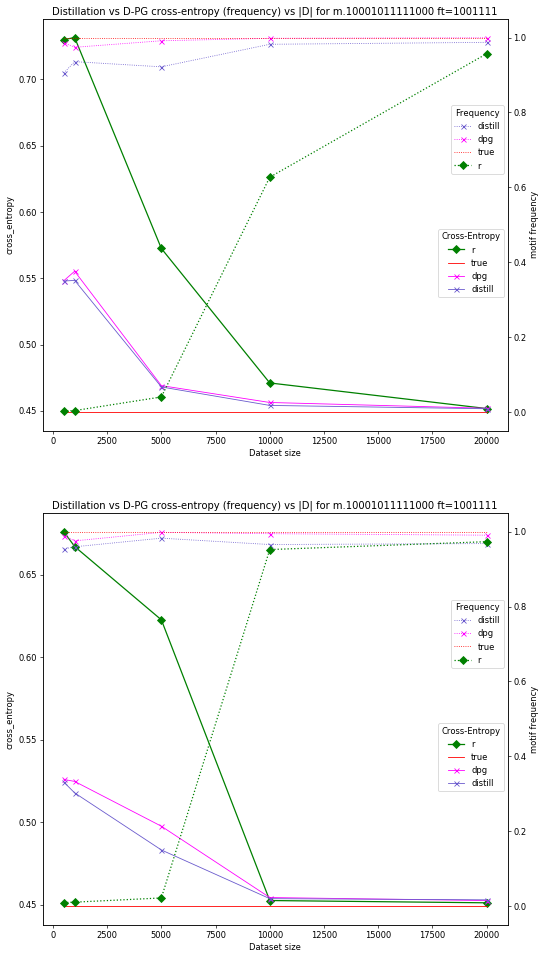

In [95]:
ms_feats = [['m.10001011111000','1001111']]
seeds = [1234, 4444]
fig=plt.figure(figsize=(10,10*len(ms_feats)*len(seeds)), dpi= 60, facecolor='w', edgecolor='k')

n = 30

data_pl = list(zip(*d_pl))
train_1 = ['rs']
train_2 = ['dpg_stable_q']
train_dpg = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]

train_2 = ['distill']
train_ds = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]
ds_range = [500, 1000, 5000, 10000, 20000]


def get_freq(s):
    # tstamp+'_'+job+'_'+str(motif_freq)+'_'+str(avg_len) +'_'+str(motif_freq_r)+'_'+str(avg_len_r)
    return float(s.split('_')[-4])

i=0
for m, feat in ms_feats:
    for sd in seeds:
        #plt.subplot(1, len(ms_feats), i+1)
        ax1 = fig.add_subplot(len(ms_feats)*len(seeds), 1, i+1)
        
        # n -> motif -> feat -> ds_size -> train_reg -> 
        #[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
        #                                 10:job,10:l1_diff]
        
        ds_ce_hybr = {t:np.array([dict_pl[n][m][feat][ds][t][sd][0][1] for ds in ds_range])
                             for t in train_ds}
        dpg_ce_hybr = {t:np.array([dict_pl[n][m][feat][ds][t][sd][0][1] for ds in ds_range])
                             for t in train_dpg}
        ce_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][0] for t in train_ds]) 
                   for ds in ds_range] 

        df1 = {'x': ds_range, 
                            'dpg':  dpg_ce_hybr['rs'+'_dpg_stable_q_normal'], 
                            'ds':  ds_ce_hybr['rs'+'_distill_normal'],
                            'ce_r': ce_r,
                            'theor': np.array([ent_motifs[n][m]]*len(ds_range))}


        ax1.plot(df1['x'], np.array(df1['ce_r']).mean(1),  
                         marker='D', color='g', label='r')
        ax1.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true')
        ax1.plot( df1['x'], df1['dpg'], marker='x', color='magenta', linewidth=1,label='dpg')
        ax1.plot( df1['x'], df1['ds'], marker='x', color='slateblue', linewidth=1,label='distill')
        ax1.set_xlabel('Dataset size')
        ax1.set_ylabel('cross_entropy')
        ax1.set_title('Distillation vs D-PG cross-entropy (frequency) vs |D| for %s ft=%s'%(m, feat))

        ce_r_max = max(ce_r[i].max() for i in range(len(ds_range)))
        diff = ce_r_max - ent_motifs[n][m]
        ax1.set_ylim(ent_motifs[n][m]-0.05*diff, ce_r_max+0.05*diff)
        
        ax2 = ax1.twinx()
        
        ds_freq_hybr = {t:np.array([get_freq(dict_pl[n][m][feat][ds][t][sd][0][5]) for ds in ds_range])
                             for t in train_ds}
        dpg_freq_hybr = {t:np.array([get_freq(dict_pl[n][m][feat][ds][t][sd][0][5]) for ds in ds_range])
                             for t in train_dpg}
        
        freq_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][11] for t in train_ds]) 
                   for ds in ds_range] 
        
        if 'mam' in m:
            theor = np.array([0.9]*len(ds_range))
        else:
            theor = np.array([1.0]*len(ds_range))

        df1 = {'x': ds_range, 
                            'dpg':  dpg_freq_hybr['rs'+'_dpg_stable_q_normal'], 
                            'ds':  ds_freq_hybr['rs'+'_distill_normal'],
                            'theor': theor,
                            'r_freq':freq_r}

        ax2.plot( df1['x'], df1['ds'], marker='x', color='slateblue', linewidth=1,label='distill',  linestyle=':')
        ax2.plot( df1['x'], df1['dpg'], marker='x', color='magenta', linewidth=1,label='dpg',  linestyle=':')
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        #ax2.plot( df1['x'], df1['snis_r'], marker='x', color='darkorange', linewidth=1,label='snis_dpg',  linestyle=':')
        ax2.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true',  linestyle=':')
        ax2.plot(df1['x'], np.array(df1['r_freq']).mean(1), marker='D', color='g', label='r',  linestyle=':')

        #ax2.xlabel('Dataset size')
        ax2.set_ylabel('motif frequency')
        #ax2.title('Motif freq vs |D| for %s ft=%s Z=%.6f'%(m, feat,z_motifs[n][m]))
        ax2.legend(title='Frequency', loc='upper right', bbox_to_anchor=(1.0, 0.8))
        ax2.set_ylim(-0.05, 1.05)
        ax1.legend(title='Cross-Entropy', loc='upper right', bbox_to_anchor=(1.0, 0.5))
        ax2.set_ylim(-0.05, 1.05)

        i += 1
        
fig.savefig("ce_freq_distil_dpg_m1s2.pdf", bbox_inches='tight')

In [96]:
# n -> motif -> feat -> ds_size -> train_reg -> seed
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
#                                 9:job,10:l1_diff,11:r_freq]

# timestamp:
# 0:mm%dd+'_'+1:%H%M+'_'+2:str(args.job)'_'+3:str(args.rl_seed)+'_'+4:str(motif_freq)+'_'+5:str(avg_len) 
# +'_'+6:str(motif_freq_r)+'_'+7:str(avg_len_r)


ms = ['m.10001011111000']
feats = [ '1001111']
seeds = [1234, 4444]

trains = [train_ds[0], train_dpg[0]]

table = PrettyTable(['|D|', 'sd', 'entp','DS:pi_ce', 'DS:r_ce', 'DS:pi_f/r_f', 'DPG:pi_ce', 'DPG:r_ce', 'DPG:pi_f/r_f', 't(DPG)/t(DS)'])
print('seed ',seeds)
ce_ratios = {t+str(ds):[] for t in train_r for ds in ds_range}
for motifs, fts in [(ms, feats)]:
    for ds in ds_range:
            for m in motifs:
                for feat in fts:
                    for sd in seeds:
                        t_ds, t_dpg = trains
                        ds_v6 = dict_pl[n][m][feat][ds][t_ds][sd][0]
                        dpg_v6 = dict_pl[n][m][feat][ds][t_dpg][sd][0]
                        entp = ds_v6[4]
                        line = []
                        for v6 in [ds_v6, dpg_v6]:
                            tmp = v6[5].split('_')
                            pi_r_freq = np.round(float(tmp[-4])/float(tmp[-2]), decimals=3)

                            pi_entp = np.round(v6[1], decimals=5)
                            r_entp = np.round(v6[0], decimals=3)
                            line += [pi_entp, r_entp, pi_r_freq]
                        line += [np.round(dpg_v6[8]/ds_v6[8], decimals=3)]
                        
                        table.add_row([ds,sd, np.round(entp, decimals=3)] + line)
    
print(table)

seed  [1234, 4444]
+-------+------+-------+----------+---------+-------------+-----------+----------+--------------+--------------+
|  |D|  |  sd  |  entp | DS:pi_ce | DS:r_ce | DS:pi_f/r_f | DPG:pi_ce | DPG:r_ce | DPG:pi_f/r_f | t(DPG)/t(DS) |
+-------+------+-------+----------+---------+-------------+-----------+----------+--------------+--------------+
|  500  | 1234 | 0.449 |  0.5479  |   0.73  |   348.231   |  0.54813  |   0.73   |   308.188    |     4.82     |
|  500  | 4444 | 0.449 | 0.52427  |  0.676  |   101.468   |  0.52588  |  0.676   |   109.911    |     6.71     |
|  1000 | 1234 | 0.449 | 0.54839  |  0.732  |   259.889   |   0.5553  |  0.732   |   270.556    |    1.014     |
|  1000 | 4444 | 0.449 | 0.51774  |  0.667  |    90.547   |  0.52469  |  0.667   |    82.678    |     13.0     |
|  5000 | 1234 | 0.449 | 0.46798  |  0.572  |    23.045   |   0.469   |  0.572   |    28.489    |    13.953    |
|  5000 | 4444 | 0.449 | 0.48316  |  0.623  |    45.083   |  0.49755  |  0.62

# Lenght Feature

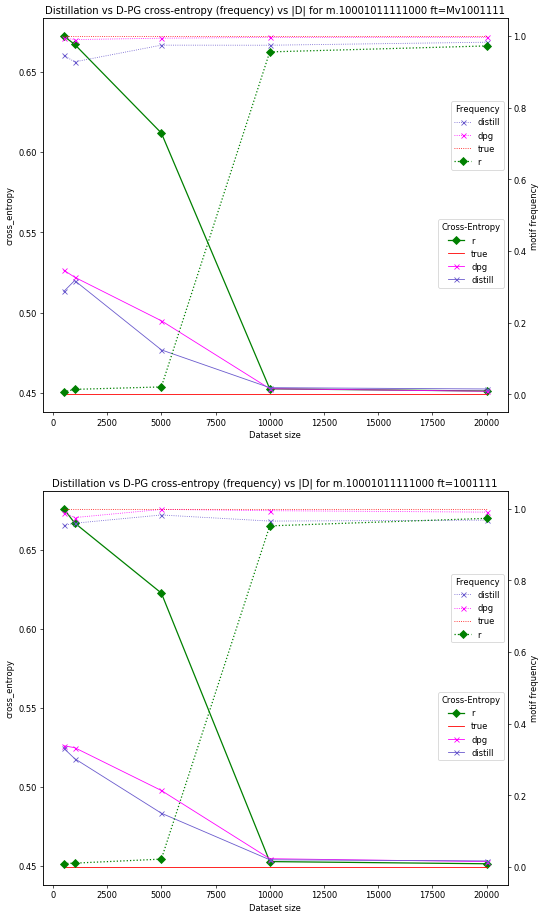

In [97]:
ms_feats = [['m.10001011111000','Mv1001111', 4444], ['m.10001011111000','1001111', 4444]]
seeds = [4444, 1234]
fig=plt.figure(figsize=(10,10*len(ms_feats)*len(seeds)), dpi= 60, facecolor='w', edgecolor='k')

n = 30

data_pl = list(zip(*d_pl))
train_1 = ['rs']
train_2 = ['dpg_stable_q']
train_dpg = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]

train_2 = ['distill']
train_ds = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]
ds_range = [500, 1000, 5000, 10000, 20000]


def get_freq(s):
    # tstamp+'_'+job+'_'+str(motif_freq)+'_'+str(avg_len) +'_'+str(motif_freq_r)+'_'+str(avg_len_r)
    return float(s.split('_')[-4])

i=0
for m, feat,sd in ms_feats:
        #plt.subplot(1, len(ms_feats), i+1)
        ax1 = fig.add_subplot(len(ms_feats)*len(seeds), 1, i+1)
        
        # n -> motif -> feat -> ds_size -> train_reg -> 
        #[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
        #                                 10:job,10:l1_diff]
        
        ds_ce_hybr = {t:np.array([dict_pl[n][m][feat][ds][t][sd][0][1] for ds in ds_range])
                             for t in train_ds}
        dpg_ce_hybr = {t:np.array([dict_pl[n][m][feat][ds][t][sd][0][1] for ds in ds_range])
                             for t in train_dpg}
        ce_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][0] for t in train_ds]) for ds in ds_range] 

        df1 = {'x': ds_range, 
                            'dpg':  dpg_ce_hybr['rs'+'_dpg_stable_q_normal'], 
                            'ds':  ds_ce_hybr['rs'+'_distill_normal'],
                            'ce_r': ce_r,
                            'theor': np.array([ent_motifs[n][m]]*len(ds_range))}


        ax1.plot(df1['x'], np.array(df1['ce_r']).mean(1),  
                         marker='D', color='g', label='r')
        ax1.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true')
        ax1.plot( df1['x'], df1['dpg'], marker='x', color='magenta', linewidth=1,label='dpg')
        ax1.plot( df1['x'], df1['ds'], marker='x', color='slateblue', linewidth=1,label='distill')
        ax1.set_xlabel('Dataset size')
        ax1.set_ylabel('cross_entropy')
        ax1.set_title('Distillation vs D-PG cross-entropy (frequency) vs |D| for %s ft=%s'%(m, feat))

        ce_r_max = max(ce_r[i].max() for i in range(len(ds_range)))
        diff = ce_r_max - ent_motifs[n][m]
        ax1.set_ylim(ent_motifs[n][m]-0.05*diff, ce_r_max+0.05*diff)
        
        ax2 = ax1.twinx()
        
        ds_freq_hybr = {t:np.array([get_freq(dict_pl[n][m][feat][ds][t][sd][0][5]) for ds in ds_range])
                             for t in train_ds}
        dpg_freq_hybr = {t:np.array([get_freq(dict_pl[n][m][feat][ds][t][sd][0][5]) for ds in ds_range])
                             for t in train_dpg}
        
        freq_r = [np.array([dict_pl[n][m][feat][ds][t][sd][0][11] for t in train_ds]) 
                   for ds in ds_range] 
        
        if 'mam' in m:
            theor = np.array([0.9]*len(ds_range))
        else:
            theor = np.array([1.0]*len(ds_range))

        df1 = {'x': ds_range, 
                            'dpg':  dpg_freq_hybr['rs'+'_dpg_stable_q_normal'], 
                            'ds':  ds_freq_hybr['rs'+'_distill_normal'],
                            'theor': theor,
                            'r_freq':freq_r}

        ax2.plot( df1['x'], df1['ds'], marker='x', color='slateblue', linewidth=1,label='distill',  linestyle=':')
        ax2.plot( df1['x'], df1['dpg'], marker='x', color='magenta', linewidth=1,label='dpg',  linestyle=':')
        #plt.plot( df1['x'], df1['snis_mix'], marker='', color='olive', linewidth=1,label='snis_mix')
        #ax2.plot( df1['x'], df1['snis_r'], marker='x', color='darkorange', linewidth=1,label='snis_dpg',  linestyle=':')
        ax2.plot( df1['x'], df1['theor'], marker='', color='red', linewidth=1,label='true',  linestyle=':')
        ax2.plot(df1['x'], np.array(df1['r_freq']).mean(1), marker='D', color='g', label='r',  linestyle=':')

        #ax2.xlabel('Dataset size')
        ax2.set_ylabel('motif frequency')
        #ax2.title('Motif freq vs |D| for %s ft=%s Z=%.6f'%(m, feat,z_motifs[n][m]))
        ax2.legend(title='Frequency', loc='upper right', bbox_to_anchor=(1.0, 0.8))
        ax2.set_ylim(-0.05, 1.05)
        ax1.legend(title='Cross-Entropy', loc='upper right', bbox_to_anchor=(1.0, 0.5))
        ax2.set_ylim(-0.05, 1.05)

        i += 1
        
fig.savefig("ce_freq_distil_dpg_m1s1_len_nolen.pdf", bbox_inches='tight')

In [98]:
# n -> motif -> feat -> ds_size -> train_reg -> seed
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
#                                 9:job,10:l1_diff,11:r_freq]

# timestamp:
# 0:mm%dd+'_'+1:%H%M+'_'+2:str(args.job)'_'+3:str(args.rl_seed)+'_'+4:str(motif_freq)+'_'+5:str(avg_len) 
# +'_'+6:str(motif_freq_r)+'_'+7:str(avg_len_r)


ms = ['m.10001011111000']
feats = [ '1001111', 'Mv1001111']
seeds = [4444]

trains = [train_ds[0], train_dpg[0]]

table = PrettyTable(['|D|', 'DS:pi_ce/pi_ce_len', 'DS:pi_f/pi_f_len', 'DPG:pi_ce/pi_ce_len', \
                     'DPG:pi_f/pi_f_len'])
print('seed ',seeds)

for ds in ds_range:
    for m in ms:
        for sd in seeds:
            line = []
            for tr in trains:
                v6_n = dict_pl[n][m][feats[0]][ds][tr][sd][0]
                v6_l = dict_pl[n][m][feats[1]][ds][tr][sd][0]
                
                tmp_n = v6_n[5].split('_')
                tmp_l = v6_l[5].split('_')
                pi_r_freq = np.round(float(tmp_n[-4])/float(tmp_l[-4]), decimals=3)
                pi_entp = np.round(v6_n[1]/v6_l[1], decimals=3)
                line += [pi_entp, pi_r_freq]

            table.add_row([ds] + line)
    
print(table)

seed  [4444]
+-------+--------------------+------------------+---------------------+-------------------+
|  |D|  | DS:pi_ce/pi_ce_len | DS:pi_f/pi_f_len | DPG:pi_ce/pi_ce_len | DPG:pi_f/pi_f_len |
+-------+--------------------+------------------+---------------------+-------------------+
|  500  |       1.022        |      1.008       |        0.999        |       0.994       |
|  1000 |       0.996        |      1.034       |        1.005        |       0.985       |
|  5000 |       1.013        |      1.008       |        1.005        |       1.004       |
| 10000 |       1.001        |      0.991       |        1.004        |       0.998       |
| 20000 |       1.001        |      0.985       |        1.003        |       0.994       |
+-------+--------------------+------------------+---------------------+-------------------+


In [99]:
# n -> motif -> feat -> ds_size -> train_reg -> seed
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
#                                 9:job,10:l1_diff,11:r_freq]

# timestamp:
# 0:mm%dd+'_'+1:%H%M+'_'+2:str(args.job)'_'+3:str(args.rl_seed)+'_'+4:str(motif_freq)+'_'+5:str(avg_len) 
# +'_'+6:str(motif_freq_r)+'_'+7:str(avg_len_r)


ms = ['m.10001011111000']
feats = [ '1001111', 'Mv1001111']
seeds = [4444]

trains = [train_ds[0], train_dpg[0]]

table = PrettyTable(['|D|', 'ft', 'entp','DS:pi_ce', 'DS:r_ce', 'DS:pi_f',  'DS:r_f', 'DPG:pi_ce', 'DPG:r_ce', \
                     'DPG:pi_f', 'DPG:r_f'])
print('seed ',seeds)

for ds in ds_range:
    for m in ms:
        for sd in seeds:
            for feat in feats:
                line = []
                for tr in trains:
                    v6 = dict_pl[n][m][feat][ds][tr][sd][0]
                    entp = np.round(v6[4], decimals=3)
                    tmp = v6[5].split('_')
                    pi_freq = np.round(float(tmp[-4]), decimals=3)
                    r_freq = np.round(float(tmp[-2]), decimals=3)
                    pi_entp = np.round(v6[1], decimals=3)
                    r_entp = np.round(v6[0], decimals=3)
                    line += [pi_entp, r_entp, pi_freq, r_freq]

                table.add_row([ds, feat, entp] + line)
    
print(table)

seed  [4444]
+-------+-----------+-------+----------+---------+---------+--------+-----------+----------+----------+---------+
|  |D|  |     ft    |  entp | DS:pi_ce | DS:r_ce | DS:pi_f | DS:r_f | DPG:pi_ce | DPG:r_ce | DPG:pi_f | DPG:r_f |
+-------+-----------+-------+----------+---------+---------+--------+-----------+----------+----------+---------+
|  500  |  1001111  | 0.449 |  0.524   |  0.676  |  0.954  | 0.009  |   0.526   |  0.676   |  0.989   |  0.009  |
|  500  | Mv1001111 | 0.449 |  0.513   |  0.672  |  0.946  | 0.006  |   0.526   |  0.676   |  0.995   |  0.009  |
|  1000 |  1001111  | 0.449 |  0.518   |  0.667  |   0.96  | 0.011  |   0.525   |  0.667   |  0.976   |  0.012  |
|  1000 | Mv1001111 | 0.449 |   0.52   |  0.667  |  0.928  | 0.014  |   0.522   |  0.667   |   0.99   |  0.011  |
|  5000 |  1001111  | 0.449 |  0.483   |  0.623  |  0.983  | 0.022  |   0.498   |  0.623   |  0.998   |  0.017  |
|  5000 | Mv1001111 | 0.449 |  0.477   |  0.612  |  0.975  |  0.02  |   0.4

# Statistics

## D-PG

In [100]:
# n -> motif -> feat -> ds_size -> train_reg -> seed
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
#                                 9:job,10:l1_diff,11:r_freq]

# timestamp:
# 0:mm%dd+'_'+1:%H%M+'_'+2:str(args.job)'_'+3:str(args.rl_seed)+'_'+4:str(motif_freq)+'_'+5:str(avg_len) 
# +'_'+6:str(motif_freq_r)+'_'+7:str(avg_len_r)


ms = ['m.10001011111000', 'm.1011100111001', 'm.1000101000101']
feats = [ '1001111', 'Mv1001111']
seeds = [1234, 4444]

train_1 = ['rs']
train_2 = ['dpg_stable_q']
train_dpg = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]

table = PrettyTable(['|D|', 'stat', 'DPG:pi_ce/ent', 'DPG:r_ce/ent', 'DPG:pi_freq/r_freq', 'DPG:pi_ce/pl_ce'])
print('seed ', seeds)
print('feats', feats)
print('motifs', ms, '\n')

ce_ratios = {t+str(ds):[] for t in train_dpg for ds in ds_range}

for ds in ds_range:
    line = np.zeros((4, len(ms)*len(feats)*len(seeds)))
    i = 0
    for m in ms:
        for feat in feats:
            for sd in seeds:
                t_dpg = train_dpg[0]
                
                if len(dict_pl[n][m][feat][ds][t_dpg][sd]) == 0: continue
                v6 = dict_pl[n][m][feat][ds][t_dpg][sd][0]
                entp = ds_v6[4]
                
                tmp = v6[5].split('_')
                pi_r_freq = np.round(float(tmp[-4])/float(tmp[-2]), decimals=3)

                pi_entp = np.round(v6[1]/entp, decimals=5)
                r_entp = np.round(v6[0]/entp, decimals=3)
                pi_pl_ce = np.round(v6[0]/v6[2], decimals=4)

                line[:,i] = np.array([pi_entp, r_entp, pi_r_freq, pi_pl_ce])
                
                i+= 1
                
    line = line[:,:i]
    np_line = list(np.round(np.mean(line, axis=1), decimals=3))
    table.add_row([ds, 'mean'] + np_line)
    np_line = list(np.round(np.std(line, axis=1), decimals=2))
    table.add_row([ds, 'std'] + np_line)
    

    
print(table)

seed  [1234, 4444]
feats ['1001111', 'Mv1001111']
motifs ['m.10001011111000', 'm.1011100111001', 'm.1000101000101'] 

+-------+------+---------------+--------------+--------------------+-----------------+
|  |D|  | stat | DPG:pi_ce/ent | DPG:r_ce/ent | DPG:pi_freq/r_freq | DPG:pi_ce/pl_ce |
+-------+------+---------------+--------------+--------------------+-----------------+
|  500  | mean |     1.211     |    1.595     |      281.506       |      1.336      |
|  500  | std  |      0.04     |     0.07     |       138.52       |       0.05      |
|  1000 | mean |     1.209     |    1.587     |      240.401       |      1.352      |
|  1000 | std  |      0.03     |     0.07     |       120.6        |       0.09      |
|  5000 | mean |     1.087     |    1.271     |       34.726       |      1.181      |
|  5000 | std  |      0.03     |     0.14     |       26.72        |       0.12      |
| 10000 | mean |     1.051     |    1.089     |       2.172        |      1.034      |
| 10000 | st

## Distillation

In [101]:
# n -> motif -> feat -> ds_size -> train_reg -> seed
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
#                                 9:job,10:l1_diff,11:r_freq]

# timestamp:
# 0:mm%dd+'_'+1:%H%M+'_'+2:str(args.job)'_'+3:str(args.rl_seed)+'_'+4:str(motif_freq)+'_'+5:str(avg_len) 
# +'_'+6:str(motif_freq_r)+'_'+7:str(avg_len_r)


ms = ['m.10001011111000', 'm.1011100111001', 'm.1000101000101']
feats = [ '1001111', 'Mv1001111']
seeds = [1234, 4444]

train_1 = ['rs', 'snis_r']
train_2 = ['distill']
train_ds = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]

table = PrettyTable(['|D|', 'stat', 'DS:pi_ce/ent', 'DS:r_ce/ent', 'DS:pi_freq/r_freq', 'DS:pi_ce/pl_ce'])
print('seed ', seeds)
print('feats', feats)
print('motifs', ms, '\n')

ce_ratios = {t+str(ds):[] for t in train_dpg for ds in ds_range}

for ds in ds_range:
    line = np.zeros((4, len(ms)*len(feats)*len(seeds)*len(train_ds)))
    i = 0
    for m in ms:
        for feat in feats:
            for sd in seeds:
                for t_ds in  train_ds:
                
                    if len(dict_pl[n][m][feat][ds][t_ds][sd]) == 0: continue
                    v6 = dict_pl[n][m][feat][ds][t_ds][sd][0]
                    entp = ds_v6[4]

                    tmp = v6[5].split('_')
                    pi_r_freq = np.round(float(tmp[-4])/float(tmp[-2]), decimals=3)

                    pi_entp = np.round(v6[1]/entp, decimals=5)
                    r_entp = np.round(v6[0]/entp, decimals=3)
                    pi_pl_ce = np.round(v6[0]/v6[2], decimals=4)

                    line[:,i] = np.array([pi_entp, r_entp, pi_r_freq, pi_pl_ce])

                    i+= 1
    line = line[:,:i]
    np_line = list(np.round(np.mean(line, axis=1), decimals=3))
    table.add_row([ds, 'mean'] + np_line)
    np_line = list(np.round(np.std(line, axis=1), decimals=2))
    table.add_row([ds, 'std'] + np_line)
    

    
print(table)

seed  [1234, 4444]
feats ['1001111', 'Mv1001111']
motifs ['m.10001011111000', 'm.1011100111001', 'm.1000101000101'] 

+-------+------+--------------+-------------+-------------------+----------------+
|  |D|  | stat | DS:pi_ce/ent | DS:r_ce/ent | DS:pi_freq/r_freq | DS:pi_ce/pl_ce |
+-------+------+--------------+-------------+-------------------+----------------+
|  500  | mean |    1.202     |    1.585    |      224.935      |     1.327      |
|  500  | std  |     0.05     |     0.08    |       84.56       |      0.04      |
|  1000 | mean |    1.192     |    1.569    |      218.239      |     1.313      |
|  1000 | std  |     0.04     |     0.08    |       133.86      |      0.02      |
|  5000 | mean |    1.067     |    1.273    |       28.688      |     1.182      |
|  5000 | std  |     0.02     |     0.13    |       20.14       |      0.11      |
| 10000 | mean |    1.036     |     1.08    |       2.036       |     1.034      |
| 10000 | std  |     0.03     |     0.08    |       

## Distillation vs D-PG

In [102]:
# n -> motif -> feat -> ds_size -> train_reg -> seed
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
#                                 9:job,10:l1_diff,11:r_freq]

# timestamp:
# 0:mm%dd+'_'+1:%H%M+'_'+2:str(args.job)'_'+3:str(args.rl_seed)+'_'+4:str(motif_freq)+'_'+5:str(avg_len) 
# +'_'+6:str(motif_freq_r)+'_'+7:str(avg_len_r)


ms = ['m.10001011111000', 'm.1011100111001', 'm.1000101000101']
feats = [ '1001111', 'Mv1001111']
seeds = [1234, 4444]

train_1 = ['rs', 'snis_r']
train_2 = ['distill']
train_ds = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]

train_1 = ['rs']
train_2 = ['dpg_stable_q']
train_dpg = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]

table = PrettyTable(['|D|', 'stat', 'DPG:pi_ce/DS:pi_ce', 'DPG:t/DS:t', 'DPG:pi_freq/DS:pi_freq'])
print('seed ', seeds)
print('feats', feats)
print('motifs', ms, '\n')

for ds in ds_range:
    ds_line = np.zeros((3, len(ms)*len(feats)*len(seeds)*len(train_ds)))
    dpg_line = np.zeros((3, len(ms)*len(feats)*len(seeds)*len(train_dpg)))
    i = 0; j = 0
    for m in ms:
        for feat in feats:
            for sd in seeds:
                for tr in  train_ds+train_dpg:
                
                    if len(dict_pl[n][m][feat][ds][tr][sd]) == 0: continue
                    v6 = dict_pl[n][m][feat][ds][tr][sd][0]
                    entp = ds_v6[4]

                    tmp = v6[5].split('_')
                    pi_r_freq = np.round(float(tmp[-4])/float(tmp[-2]), decimals=3)

                    pi_entp = np.round(v6[1]/entp, decimals=5)
                    time = np.round(v6[8], decimals=3)
                    if 'distill' in tr:
                        ds_line[:,i] = np.array([pi_entp, time, pi_r_freq])
                        i+= 1
                    elif 'dpg' in tr:
                        dpg_line[:,j] = np.array([pi_entp, time, pi_r_freq])
                        j+= 1
                        
    ds_line = ds_line[:,:i]
    dpg_line = dpg_line[:,:j]
    
    np_line = list(np.round(np.divide(np.mean(dpg_line, axis=1), np.mean(ds_line, axis=1)), decimals=3))
    table.add_row([ds, 'mean'] + np_line)
    

    
print(table)

seed  [1234, 4444]
feats ['1001111', 'Mv1001111']
motifs ['m.10001011111000', 'm.1011100111001', 'm.1000101000101'] 

+-------+------+--------------------+------------+------------------------+
|  |D|  | stat | DPG:pi_ce/DS:pi_ce | DPG:t/DS:t | DPG:pi_freq/DS:pi_freq |
+-------+------+--------------------+------------+------------------------+
|  500  | mean |       1.008        |   1.534    |         1.252          |
|  1000 | mean |       1.014        |   3.178    |         1.102          |
|  5000 | mean |       1.019        |   4.935    |          1.21          |
| 10000 | mean |       1.014        |   51.477   |         1.067          |
| 20000 | mean |       1.004        |   21.338   |         1.023          |
+-------+------+--------------------+------------+------------------------+


In [103]:
# n -> motif -> feat -> ds_size -> train_reg -> seed
#[0:test_ce_r,1:test_ce_pi,2:test_ce_pl,3:train_l1_pl,4:theor_ent,5:tstamp,6:lambd,7:mfeat_pl,8:plambda_time,
#                                 9:job,10:l1_diff,11:r_freq]

# timestamp:
# 0:mm%dd+'_'+1:%H%M+'_'+2:str(args.job)'_'+3:str(args.rl_seed)+'_'+4:str(motif_freq)+'_'+5:str(avg_len) 
# +'_'+6:str(motif_freq_r)+'_'+7:str(avg_len_r)


ms = ['m.10001011111000', 'm.1011100111001', 'm.1000101000101']
feats = [ '1001111', 'Mv1001111']
seeds = [1234, 4444]

train_1 = ['rs', 'snis_r']
train_2 = ['distill']
train_ds = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]

train_1 = ['rs']
train_2 = ['dpg_stable_q']
train_dpg = [t1+'_'+t2+'_'+'normal' for t1 in train_1 for t2 in train_2]

table = PrettyTable(['|D|', 'stat', 'DPG:pi_ce', 'DPG:pi_freq', 'DS:pi_ce','DS:pi_freq'])
print('seed ', seeds)
print('feats', feats)
print('motifs', ms, '\n')

for ds in ds_range:
    ds_line = np.zeros((2, len(ms)*len(feats)*len(seeds)*len(train_ds)))
    dpg_line = np.zeros((2, len(ms)*len(feats)*len(seeds)*len(train_dpg)))
    i = 0; j = 0
    for m in ms:
        for feat in feats:
            for sd in seeds:
                for tr in  train_ds+train_dpg:
                
                    if len(dict_pl[n][m][feat][ds][tr][sd]) == 0: continue
                    v6 = dict_pl[n][m][feat][ds][tr][sd][0]
                    entp = ds_v6[4]

                    tmp = v6[5].split('_')
                    pi_r_freq = np.round(float(tmp[-4])/float(tmp[-2]), decimals=3)

                    pi_entp = np.round(v6[1]/entp, decimals=5)
                    time = np.round(v6[8], decimals=3)
                    if 'distill' in tr:
                        ds_line[:,i] = np.array([pi_entp, pi_r_freq])
                        i+= 1
                    elif 'dpg' in tr:
                        dpg_line[:,j] = np.array([pi_entp, pi_r_freq])
                        j+= 1
                        
    ds_line = ds_line[:,:i]
    dpg_line = dpg_line[:,:j]
    
    np_line = list(np.round(np.concatenate((np.mean(dpg_line, axis=1), np.mean(ds_line, axis=1)),axis=0), decimals=3))
    table.add_row([ds, 'mean'] + np_line)
    np_line = list(np.round(np.concatenate((np.std(dpg_line, axis=1), np.std(ds_line, axis=1)), axis=0), decimals=3))
    table.add_row([ds, 'std'] + np_line)
    

    
print(table)

seed  [1234, 4444]
feats ['1001111', 'Mv1001111']
motifs ['m.10001011111000', 'm.1011100111001', 'm.1000101000101'] 

+-------+------+-----------+-------------+----------+------------+
|  |D|  | stat | DPG:pi_ce | DPG:pi_freq | DS:pi_ce | DS:pi_freq |
+-------+------+-----------+-------------+----------+------------+
|  500  | mean |   1.211   |   281.506   |  1.202   |  224.935   |
|  500  | std  |   0.041   |    138.52   |  0.049   |   84.564   |
|  1000 | mean |   1.209   |   240.401   |  1.192   |  218.239   |
|  1000 | std  |   0.033   |   120.597   |  0.036   |  133.864   |
|  5000 | mean |   1.087   |    34.726   |  1.067   |   28.688   |
|  5000 | std  |   0.028   |    26.719   |   0.02   |   20.137   |
| 10000 | mean |   1.051   |    2.172    |  1.036   |   2.036    |
| 10000 | std  |   0.041   |    1.444    |  0.033   |   1.347    |
| 20000 | mean |   1.033   |    1.034    |  1.028   |    1.01    |
| 20000 | std  |   0.027   |    0.011    |  0.027   |   0.012    |
+-------+--